In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import random
from tqdm.notebook import tqdm
from scipy.linalg import eig, eigh
import time
from copy import deepcopy
import scipy.stats as stats
import networkx as nx
from networkx import Graph, DiGraph
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
from ipywidgets import widgets, interactive, fixed, interact, interactive_output, VBox, HBox, Layout
import math
import cmath
import cupy as cp
import scipy.sparse as sparse
import cupyx.scipy.sparse as cp_sparse
from cupy.linalg import eigh as cp_eigh
from sklearn.preprocessing import normalize, scale
from sys import getsizeof

In [2]:
IMAGE_PATH = "ThesisKI/Images/"

COLOUR_LIST = ["skyblue", "coral", "palegreen", "palevioletred", "palegoldenrod"]

text_style = {"description_width":"initial"}

cmap_var = widgets.Dropdown(options=["degree",
                                     "degree_frac",
                                     "indegree",
                                     "indegree_frac",
                                     "outdegree",
                                     "outdegree_frac",
                                     "t_degree",
                                     "t_degree_frac",
                                     "t_indegree",
                                     "t_indegree_frac",
                                     "t_outdegree",
                                     "t_outdegree_frac",
                                     "truth",
                                     "in_prominence",
                                     "prominence",
                                     "out_prominence",
                                     "t_step_prom_in",
                                     "t_step_prom_out",
                                     "t_step_prom",
                                     "non-coop",
                                     "None"],
                                    value="truth",
                                    description="Labeled Variable:",
                                    style=text_style)
    
layout_func = widgets.Dropdown(options=["kamada-kawai",
                                        "fruchterman-reingold",
                                        "random",
                                        "spiral",
                                        "shell",
                                        "spring",
                                        "spectral"],
                               value="kamada-kawai",
                               description="Graph Layout:",\
                               style=text_style)

comparison_func = widgets.Dropdown(options=["mean",
                                            "std"],
                                   value="mean",
                                   description="Applied Function:",
                                   style=text_style)

initialization_func = widgets.Dropdown(options=["overlap",
                                                "belief",
                                                "random",
                                                "uniform"],
                                       value="uniform",
                                       description="Weight Initialization",
                                      style=text_style)

measure_func = widgets.Dropdown(options=["mean",
                                         "std",
                                         "median"],
                                value="mean",
                                description="Measurement used:",
                                style=text_style)

convergence_measure_func = widgets.Dropdown(options=["mean",
                                                    "std"],
                                           value="mean",
                                           description="Measurement of convergence",
                                           style=text_style)

In [4]:
class Network():
    def __init__(self, p_selflink=1, n_agents=1000, directed=True, sparse_gen=True, n_non_coop=0,
                 increase_degree=True, show_network=False, show_degree_dis=False, GPU=False,
                 weight_comparison=False, show_convergence=False, convergence_comparison=False,
                 show_wisdom=False, double_non_coop=False, degree_sep_non_coop=False,
                 coop_non_coop_conv=False, coop_non_coop_conv_belief=False, agent_degree_dis=False):
        
        # Set font size to default
        plt.rcParams.update({'font.size': 10})
        
        self.directed = directed
            
        self.increase_degree = increase_degree
        
        self.truth = random.uniform(0,1)
        self.p_selflink = p_selflink
        self.non_cooperative = 0
        self.n_non_coop = n_non_coop
        self.weights = self.grow_network_instant(n_agents=n_agents, directed=directed,
                                                 increase_degree=increase_degree, sparse_gen=sparse_gen)   
        
        self.beliefs, self.truth_new = self.grow_beliefs(n_agents, self.truth)
        
        self.non_coop_links, self.non_coop_beliefs = self.gen_non_coop(self.weights, self.beliefs,
                                                                       self.truth_new, n=self.n_non_coop)
        
        non_coop_weights, non_coop_beliefs = self.add_non_coop(self.weights, self.non_coop_links,
                                                               self.beliefs, self.non_coop_beliefs)
        

        if False:
            self.degroots_wisdom(e1=[],
                                 e2=[], 
                                 diff=True, iterations=10, t=True, 
                                 thresholds=[.1, .2, .3, .4, .5, .6, .7, .8, .9],
                                 save_img=True, std=True, 
                                 alpha=[])
        
        if False:
            self.t_iter_instant(100, step_size=5, save_img=False)
        
        if False:
            self.t_to_conv_plot(self.weights, self.beliefs, e=[0, .2, .4, .8, 1], step_size=10,
                                converge_func="e", save_img=False)
        
        if False:
            self.memory_usage(10000, save_img=True)
            self.compare_gen_time(10000, save_img=True)
            
        
        #self.compare_e_degroots(self.weights, self.beliefs, 30, .1)        
        
        if False:
            self.compare_degroots(self.weights, self.beliefs, 30, [0, .05, .1, .15], save_img=False)
        
        if show_network:            
            save_figure_widget = widgets.Checkbox(False, description="Save Figure", style=text_style)
            node_numbers_widget = widgets.Checkbox(False, description="Number Nodes", style=text_style)
            cmap_var_widget = cmap_var
            layout_function_widget = layout_func
            save_name_widget = widgets.Text("Graph", description="Save Name", style=text_style)
            network_size_widget = widgets.IntSlider(30, 10, 1000, 1, description="Network Size")
            edge_cmap_widget = widgets.Checkbox(False, description="Edge cmap",style=text_style)
            t_widget = widgets.IntSlider(0, 0, 5000, 1, description="t")
            show_t_weights_widget = widgets.Checkbox(False, description="t-weights", style=text_style)
            initialize_weights_widget = initialization_func
            non_coop_widget = widgets.Checkbox(False, description="Non-cooperative", style=text_style)
            show_nodes_widget = widgets.Checkbox(True, description="Show Nodes", style=text_style)
            show_edges_widget = widgets.Checkbox(True, description="Show Edges", style=text_style)
            
            Vbox1 = VBox([cmap_var, layout_func])
            Vbox2 = VBox([initialization_func, save_name_widget])
            text_widgets = HBox([Vbox1, Vbox2])            
            
            horizontal_layout1 = Layout(width="70%",
                                       margin="0",
                                       padding="0",
                                       border="0")
            horizontal_layout2 = Layout(width="52.5%",
                                       margin="0",
                                       padding="0",
                                       border="0")
            
            Hbox2 = HBox([show_edges_widget, show_nodes_widget, node_numbers_widget, edge_cmap_widget],
                         layout=horizontal_layout1)
            Hbox3 = HBox([non_coop_widget, show_t_weights_widget, save_figure_widget],
                         layout=horizontal_layout2)
            
            check_widgets = VBox([Hbox2, Hbox3])
            
            slider_widgets = HBox([network_size_widget, t_widget])
            
            final_widgets = VBox([text_widgets, slider_widgets, check_widgets])
            
            
            
            input_dict = {"weights":fixed(self.weights), "save_extension":fixed(".png"),
                          "save_figure":save_figure_widget, "node_numbers":node_numbers_widget, "directed":fixed(directed),
                          "cmap_var":cmap_var, "layout_function":layout_func, "save_name":save_name_widget, 
                          "network_size":network_size_widget, "beliefs":fixed(self.beliefs), 
                          "edge_cmap":edge_cmap_widget, "t":t_widget, "show_weights_t":show_t_weights_widget,
                          "initialize_weights":initialization_func, "sparse_gen":fixed(sparse_gen),
                          "non_coop":non_coop_widget, "show_nodes":show_nodes_widget, "show_edges":show_edges_widget}
            
            out = interactive_output(self.draw_network, input_dict)
            
            display(final_widgets, out)
        
        if show_degree_dis:
            interact(self.degree_distribution_interactive, weights=fixed(self.weights), 
                     directed=fixed(directed), n_agents=(0, 1000, 1), sparse_gen=fixed(sparse_gen),
                     prob_func_degree=fixed(np.random.normal), save_extension=fixed(".png"))
            
        if agent_degree_dis:
            self.agent_degree_distribution(averaging_step=100, save_image=True, directed=directed,
                                           increase_degree=increase_degree)
        
        if weight_comparison:
            interact(self.compare_weights, weights=fixed(self.weights), beliefs=fixed(self.beliefs),
                     func_name=measure_func, normalize=False, sparse_gen=fixed(sparse_gen), 
                     save_img=False, save_name=fixed("Weights"), save_extension=fixed(".png"),
                     save_path=fixed(IMAGE_PATH))
            
        if show_convergence:
            self.plot_convergence_network_t(self.weights, self.beliefs, save_img=False)
            
        if convergence_comparison:
            networks = []
            for i in range(2):
                for j in range(2):
                    tmp_network = self.grow_network_instant(n_agents=n_agents, directed=j, 
                                                            increase_degree=i, sparse_gen=sparse_gen)
                    networks.append(tmp_network)
            self.plot_convergence_comparison_t(networks, beliefs=self.beliefs, save_img=False)
            
        if show_wisdom:
            self.plot_wisdom_convergence(self.weights, self.beliefs, truth=[self.truth, self.truth_new],
                                         diff=True, save_img=False)
            
        if double_non_coop:
            belief_non_coop1=widgets.Checkbox(False, description="Non-coop1 Belief", style=text_style)
            belief_non_coop2=widgets.Checkbox(False, description="Non_coop2 Belief", style=text_style) 
            belief_non_coop_mean=widgets.Checkbox(True, description="Mean Belief Non-coop", style=text_style)
            truth=widgets.Checkbox(True, description="Truth", style=text_style) 
            non_coop_mean=widgets.Checkbox(True, description="Mean conv. belief non-coop", style=text_style) 
            non_coop_std=widgets.Checkbox(False, description="Std conv. belief non-coop", style=text_style)
            non_coop_s=widgets.Checkbox(False, description="s belief non-coop", style=text_style) 
            coop_s=widgets.Checkbox(True, description="s belief coop", style=text_style)
            weighted_avg_non_coop=widgets.Checkbox(True, description="weighted avg", style=text_style)
            
            horizontal_layout1 = Layout(width="70%",
                                       margin="0",
                                       padding="0",
                                       border="0")
            
            Hbox1 = HBox([belief_non_coop1, belief_non_coop2, belief_non_coop_mean, truth],
                         layout=horizontal_layout1)
            Hbox2 = HBox([non_coop_mean, non_coop_std, non_coop_s, coop_s],
                         layout=horizontal_layout1)
            Vbox = VBox([Hbox1, Hbox2])
            
            interactivity_dict = {"weights":fixed(self.weights), 
                                  "non_coop_links":fixed(self.non_coop_links), 
                                  "beliefs":fixed(self.beliefs), 
                                  "non_coop_beliefs":fixed(self.non_coop_beliefs),
                                  "belief_non_coop1":belief_non_coop1,
                                  "belief_non_coop2":belief_non_coop2,
                                  "belief_non_coop_mean":belief_non_coop_mean,
                                  "truth":truth,
                                  "non_coop_mean_bool":non_coop_mean,
                                  "non_coop_std_bool":non_coop_std,
                                  "non_coop_s_bool":non_coop_s,
                                  "coop_s_bool":coop_s,
                                  "weighted_avg_non_coop_bool":weighted_avg_non_coop,
                                  "save_fig":fixed(False)}
            
            out = interactive_output(self.double_non_coop_plot, interactivity_dict)
            
            display(Vbox, out)
            
        if degree_sep_non_coop:
            self.degree_sep_non_coop(self.weights, self.non_coop_links, 
                                     self.beliefs, self.non_coop_beliefs, save_fig=False)
            
        if coop_non_coop_conv:
            self.coop_non_coop_convergence(self.weights, self.non_coop_links,
                                       self.beliefs, self.non_coop_beliefs, t=20, save_fig=False)
            
        if coop_non_coop_conv_belief:
            self.compare_coop_non_coop(self.weights, self.beliefs, self.non_coop_links, 
                                       self.non_coop_beliefs, save_img=False,
                                       truth=[self.truth_new, self.non_coop_beliefs[0]])
            
    """
    Functional functions.
    Up-to-date and work as intended.
    """
    
    # PLOTTING FUNCTIONS
    
    # Functional
    def agent_degree_distribution(self, n_agents=1000, increase_degree=False, directed=True,
                                  comparison=False, save_image=False, save_path=IMAGE_PATH,
                                  show_plot=True, averaging_step=1, save_extension=".png",
                                  prob_func_degree=np.random.normal, prob_func_degree_param=[2,1]):
        
        """
        Creates barplots of the agents degree. 
        The degree is then averaged over every averaging_step agents, 
        to ensure a readable resolution of the barplot.
        
        Input:
            n_agents: int, number of agents the generated network will have.
            increase_degree: bool, whether the agents should receive additional links.
            comparison: bool, whether to compare the increased degree and standard degree.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
            instant: bool, default=True, whether the instant generation method 
                should be used.
            averaging_step: int, default=1, the amount of agents a bin should represent, meaning
                the amount of agents the degree will be averaged over.
            save_extension: string, default=.png, extension, should the plot be saved.
            prob_func_degree: np.random probability distribution, default=np.random.normal,
                determines which probability distriubtion is used for determining the increased degree.
            prob_func_degree_param: iterable, default=[2,1], parameters to be used for the probability
                distribution of the increased degree.
        """
        
        # Create the x-axis
        x = [i+1 for i in range(int(n_agents/averaging_step))]
        # Create an array to use in the averaging of the degrees.
        # Needs to have the same size as x
        avg = np.arange(n_agents)//averaging_step
        
        x_labels = [str((n-1)*averaging_step) + "-" + str(n*averaging_step) if n != 1 else "1-" + str(n*averaging_step) for n in x]
        
        # Title of the plot
        title = f"Average Degree, Per {averaging_step} Agents \n n={n_agents}, 1 Bin Is Avg. Of {averaging_step} agents"
        
        if not comparison:
            if increase_degree:
                title = "Increased " + title
                save_name = "IncreasedPerAgent"
            else:
                title = "Standard " + title
                save_name = "StandardPerAgent"
                
            # Generate the network
            network = self.grow_network_instant(n_agents, increase_degree=increase_degree, 
                                                directed=directed, prob_func_degree=prob_func_degree).A
            
            # Get in and out degree of network
            in_degree = np.count_nonzero(network, axis=1)
            out_degree = np.count_nonzero(network, axis=0)
            
            # Average the degrees over the bins to ensure readable resolution in the plot
            in_degree_avg = np.bincount(avg, out_degree)/np.bincount(avg)
            out_degree_avg = np.bincount(avg, in_degree)/np.bincount(avg)
            
            # Create plots for directed network
            if directed:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create the specifics of the subplots
                fig, axs = plt.subplots(1, 2, sharey=True)
                fig.suptitle(title)
                axs[0].bar(x=x, height=out_degree_avg, color="skyblue", edgecolor="slategrey")
                axs[0].set_title("Out-degree per agent")
                axs[0].set_xticks(x)
                axs[0].set_xticklabels(x_labels, rotation=-45, ha="left", rotation_mode="anchor")
                axs[1].bar(x=x, height=in_degree_avg, color="skyblue", edgecolor="slategrey")
                axs[1].set_title("In-degree per agent")
                axs[1].set_xticks(x)
                axs[1].set_xticklabels(x_labels, rotation=-45, ha="left",  rotation_mode="anchor")

                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agent Numbers"
                    ylabel = "Average Degree"
                    ax.set(xlabel=xlabel, ylabel=ylabel)
                    
            else:
                title = "Undirected " + title
                save_name = "Undirected" + save_name
                plt.bar(x, in_degree_avg, color="skyblue", edgecolor="slategrey")
                plt.title(title)
                plt.xlabel("Agent")
                plt.ylabel("Degree")
            
        else:
            # Generate two networks, with both increased degree and standard degree
            # Then creates a subplot comparing them
            save_name = "ComparisonPerAgent"
            
            # Generate two networks
            network = self.grow_network_instant(n_agents, increase_degree=False)
            network_increase = self.grow_network_instant(n_agents, increase_degree=True)
            
            # Compute & average standard degrees
            in_degree_std = np.count_nonzero(network, axis=1)
            out_degree_std = np.count_nonzero(network, axis=0)            
            in_degree_std_avg = np.bincount(avg, out_degree_std)/np.bincount(avg)
            out_degree_std_avg = np.bincount(avg, in_degree_std)/np.bincount(avg)
            
            # Compute & average increased degrees
            in_degree_inc = np.count_nonzero(network_increase, axis=1)
            out_degree_inc = np.count_nonzero(network_increase, axis=0)            
            in_degree_inc_avg = np.bincount(avg, out_degree_inc)/np.bincount(avg)
            out_degree_inc_avg = np.bincount(avg, in_degree_inc)/np.bincount(avg)            
            
            if directed:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create specifics of subplots
                fig, axs = plt.subplots(2, 2, sharey=True)
                fig.suptitle(title)
                axs[0, 0].bar(x=x, height=out_degree_std_avg, color="skyblue", edgecolor="slategrey")
                axs[0, 0].set_title("Standard Out-degree")
                axs[0, 1].bar(x=x, height=in_degree_std_avg, color="skyblue", edgecolor="slategrey")
                axs[0, 1].set_title("Standard In-degree")

                axs[1, 0].bar(x=x, height=out_degree_inc_avg, color="coral", edgecolor="slategrey")
                axs[1, 0].set_title("Increased Out-degree")
                axs[1, 1].bar(x=x, height=in_degree_inc_avg, color="coral", edgecolor="slategrey")
                axs[1, 1].set_title("Increased In-degree")
                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agent"
                    ax.set(xlabel=xlabel, ylabel="Degree")
                    
            else:
                title = "Directed " + title
                save_name = "Directed" + save_name
                # Create the specifics of the subplots
                fig, axs = plt.subplots(1, 2, sharey=True)
                fig.suptitle(title)
                axs[0].bar(x=x, height=in_degree_std_avg, color="skyblue", edgecolor="slategrey")
                axs[0].set_title("Standard degree per agent")
                axs[1].bar(x=x, height=in_degree_inc_avg, color="coral", edgecolor="slategrey")
                axs[1].set_title("Increased degree per agent")

                fig.tight_layout()
                for ax in axs.flat:
                    xlabel = "Agents"
                    ylabel = "Degree"
                    ax.set(xlabel=xlabel, ylabel=ylabel)
        if directed or comparison:  
            for ax in fig.get_axes():
                ax.label_outer()
        
        if save_image:
            plt.savefig(IMAGE_PATH+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
        if show_plot:
            plt.show()
    
    # Functional
    def speed_test(self, n_agents, save_img=False, save_path=IMAGE_PATH, save_extension=".png",
                   show_plot=True, iterations=10, step_size=.1, increase_degree=False):
        """
        Compare the time to generate networks of up to n_agents using the 
        different generation methods, averaged over a given number of iterations.
        
        Input:
            n_agents: int, upper bound of network size.
            save_image: bool, default=False, whether the plot should be saved.
            save_path: string, default=IMAGE_PATH, the path to which the plot 
                should be saved.
            show_plot: bool, default=True, whether the plot should be shown.
            iterations: int, default=10, over how many iterations the time
                will be averaged.
            step_size: float, default=.1, used to indicate step size for generating
                the models, given by int(step_size*n_agents).
            save_extension = string, default=.png, extension, should the plot be saved.
        """
        plt.rcParams.update({'font.size': 10})
        instant = []
        for k in tqdm(range(iterations)):
            instant_time = []
            sizes = []
            # Generate models of up to n_agents, increasing by step_size
            for i in range(0, n_agents+1, int(step_size*n_agents)):
                sizes.append(i)
                # Timing of instant generation of network
                t_start = time.perf_counter()
                network_instant = self.grow_network_instant(n_agents=i, increase_degree=increase_degree)                
                t_end = time.perf_counter()
                # Compute passed time in ms
                instant_time.append((t_end-t_start)*1000)
                
            instant.append(instant_time)          
        
        # Generate plots for the measurements
        plt.plot(sizes, np.mean(np.array(instant), axis=0), label="Instant", color="skyblue")
        plt.legend()
        plt.xlabel("Number of agents in network")
        plt.ylabel("Generation time (ms)")
        #plt.title("Network generation time vs. agents")
        if save_img:
            plt.savefig(IMAGE_PATH+"GenTime2"+save_extension)
        if show_plot:
            plt.show()        
    
    # Functional
    def degree_distribution_interactive(self, weights, n_agents=1000, save_image=False, 
                                        save_path=IMAGE_PATH, save_extension=".png", 
                                        directed=True, sparse_gen=True):
        """
        Plots the degree distribution of a given input network for the first n_agents, agents.
        When given a directed network it shows both the in and out degree.
        
        Input:
            weights: np.array, the adjacency matrix of the network.
            n_agents: int, number of agents the generated network will have.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
            save_extension: string, default=.png, extension, should the plot be saved.
            directed=bool, default=True, whether the given network is directed or not.
        """
        
        # Set font size to default
        plt.rcParams.update({'font.size': 12})
        
        if sparse_gen:
            weights = weights.toarray()
        # Get the network at the desired number of agents
        weights = weights[:n_agents, :n_agents]
        
        if directed:
            # Get the degrees
            in_degree = np.count_nonzero(weights, axis=1)
            out_degree = np.count_nonzero(weights, axis=0)
            
            # Set plot specifics
            fig, axs = plt.subplots(1,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            save_name = "DegreeDirected"
            fig.suptitle(f"Directed Degree Distribution, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0].hist(out_degree, edgecolor="slategrey", align="left",
                           color="skyblue", bins=range(np.amin(out_degree), np.amax(out_degree)))
            axs[0].set_title("Out-Degree Histogram")
            axs[0].set_xlabel("Out-degree")
            axs[0].set_ylabel("Agents")
            axs[0].set_xticks(range(np.amin(out_degree), np.amax(out_degree), 2))
            axs[1].hist(in_degree, edgecolor="slategrey", align="left",
                           color="skyblue", bins=range(np.amin(in_degree), np.amax(in_degree)))
            axs[1].set_title("In-Degree Histogram")
            axs[1].set_xlabel("In-degree")
            axs[1].set_xticks(range(np.amin(in_degree), np.amax(in_degree), 2))
            fig.tight_layout()           
            
        else:
            # Get degree
            degree = np.count_nonzero(weights, axis=1)
            # Set plot specifics
            save_name="DegreeUndirected"       
            plt.hist(degree, edgecolor="slategrey", align="left",
                     color="skyblue", bins=range(np.amin(degree), np.amax(degree)))
            plt.title(f"Undirected Degree Distribution, n={n_agents}")
            plt.xlabel("Degree")
            plt.ylabel("Agents")

        if save_image:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(IMAGE_PATH+save_name+save_extension)
        plt.show()  
    
    # Functional
    def compare_gen_time(self, n_agents, step_factor=.1, n_mean=10, save_img=False):
        plt.rcParams.update({'font.size': 14})
        # Lists for gathering data for plots
        CPU_std_dir, CPU_std_dir_inc, CPU_std_udir, CPU_std_udir_inc = [], [], [], []
        CPU_sprs_dir, CPU_sprs_dir_inc, CPU_sprs_udir, CPU_sprs_udir_inc = [], [], [], []
        # Loop for the amount of iterations the mean will be taken over.
        for j in tqdm(range(n_mean)):            
            print("CPU Generation")
            print()
            print("Standard Matrix Generation")
            print("--------------------------")
            std_udir_std_np, std_udir_inc_np, std_dir_std_np, std_dir_inc_np = [], [], [], []

            growth_step = int(step_factor*n_agents)
            for i in range(growth_step, n_agents+growth_step, growth_step):
                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=False,
                                          increase_degree=False, sparse_gen=False)
                end_time = time.perf_counter()
                std_udir_std_np.append((end_time-start_time)*1000)

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=False,
                                          increase_degree=True, sparse_gen=False)
                end_time = time.perf_counter()
                std_udir_inc_np.append((end_time-start_time)*1000)  

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=True,
                                          increase_degree=False, sparse_gen=False)
                end_time = time.perf_counter()
                std_dir_std_np.append((end_time-start_time)*1000)

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=True,
                                          increase_degree=True, sparse_gen=False)
                end_time = time.perf_counter()
                std_dir_inc_np.append((end_time-start_time)*1000)
            
            sprs_udir_std_np, sprs_udir_inc_np, sprs_dir_std_np, sprs_dir_inc_np = [], [], [], []
            print("Sparse Matrix Generation")
            print("--------------------------")
            for i in range(growth_step, n_agents+growth_step, growth_step):
                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=False,
                                          increase_degree=False, sparse_gen=True)
                end_time = time.perf_counter()
                sprs_udir_std_np.append((end_time-start_time)*1000)

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=False,
                                          increase_degree=True, sparse_gen=True)
                end_time = time.perf_counter()
                sprs_udir_inc_np.append((end_time-start_time)*1000)

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=True,
                                          increase_degree=False, sparse_gen=True)
                end_time = time.perf_counter()
                sprs_dir_std_np.append((end_time-start_time)*1000)

                start_time = time.perf_counter()
                self.grow_network_instant(n_agents=i, directed=True,
                                          increase_degree=True, sparse_gen=True)
                end_time = time.perf_counter()
                sprs_dir_inc_np.append((end_time-start_time)*1000)
    
           
        CPU_std_dir.append(std_dir_std_np)
        CPU_std_dir_inc.append(std_dir_inc_np)
        CPU_std_udir.append(std_udir_std_np)
        CPU_std_udir_inc.append(std_udir_inc_np)        
                
        CPU_sprs_dir.append(sprs_dir_std_np)
        CPU_sprs_dir_inc.append(sprs_dir_inc_np)
        CPU_sprs_udir.append(sprs_udir_std_np)
        CPU_sprs_udir_inc.append(sprs_udir_inc_np)    
        
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_std_dir).mean(axis=0), color="skyblue", label="Directed")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_std_udir).mean(axis=0), color="coral", label="Undirected")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_sprs_dir).mean(axis=0), color="palegreen", label="Sparse, directed")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_sprs_udir).mean(axis=0), color="palegoldenrod", label="Sparse, undirected")
        plt.title("Network generation time, unincreased degree")
        plt.xlabel("Number of agents")
        plt.ylabel("Time (ms)")
        plt.legend()
        if save_img:
            plt.savefig(IMAGE_PATH+"CPU.png")        
        plt.show()
        
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_std_dir_inc).mean(axis=0), color="skyblue", label="Directed")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_std_udir_inc).mean(axis=0), color="coral", label="Undirected")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_sprs_dir_inc).mean(axis=0), color="palegreen", label="Sparse, directed")
        plt.plot(range(growth_step, n_agents+growth_step, growth_step), 
                 np.array(CPU_sprs_udir_inc).mean(axis=0), color="palegoldenrod", label="Sparse, undirected")
        plt.title("Network generation time, increased degree")
        plt.xlabel("Number of agents")
        plt.ylabel("Time (ms)")
        plt.legend()
        plt.legend()
        if save_img:
            plt.savefig(IMAGE_PATH+"CPU_inc.png")
        plt.show()
    
    # Functional - GPU kinda flakey
    def exponentiation_time(self, n_agents, power, GPU=False, 
                            directed=True, increase_degree=False):
        """
        Compare the time it takes to raise a network of a given size
        to a given power, in seconds. By default the comparison is between
        a dense matrix and a sparse matrix, but GPU can be enabled.
        
        Note: GPU can be  flakey and often has unknownCUDAErrors
        
        Input:
            n_agents: int, size of the network in agents.
            power: int, which power to raise the network to.
            GPU: bool, default=False, whether to usse the GPU as well.
            directed: bool, default=True, whether to generate a directed network.
            increase_degree: bool, default=False, whether the network should have
                an increased degree.
        """
        
        # Create a network
        T0 = self.grow_network_instant(n_agents, increase_degree=increase_degree, 
                                       directed=directed, sparse_gen=True)
        # Store to original network
        T_sparse = T0
        start_time = time.perf_counter()
        # Mulitply the current network with the original repeatedly.
        for i in range(power):
            T_sparse = T_sparse*T0
        end_time = time.perf_counter()
        print(f"Sparse exponentiation time: {end_time - start_time}")
        
        # Create a network
        T0 = self.grow_network_instant(n_agents, increase_degree=increase_degree, 
                                       directed=directed, sparse_gen=False)
        T_dense_CPU = T0
        start_time = time.perf_counter()
        # Mulitply the current network with the original repeatedly.
        for i in range(power):
            T = T_dense_CPU@T0
        end_time = time.perf_counter()
        print(f"Dense exponentiation time CPU: {end_time - start_time}")
        
        if GPU:
            # Create a network
            T0 = self.grow_network_instant(n_agents, increase_degree=increase_degree, 
                                           directed=directed, sparse_gen=False, GPU=GPU)
            T_dense_GPU = T0
            start_time = time.perf_counter()
            # Mulitply the current network with the original repeatedly.
            for i in range(power):
                T_dense_GPU = cp.matmul(T_dense_GPU, T0)
            end_time = time.perf_counter()
            print(f"Dense exponentiation time CPU: {end_time - start_time}")
    
    # NETWORK GROWING FUNCTIONS
    
    # Functional -- Documentation outdated
    def normalize_weights(self, weights, GPU=False):
        """
        Generates a stochastic adjacency matrix 
        based on the weight matrix.
        
        Input:
            weights: np.array, network weight matrix
        Output:
            stochastic weight matrix.
        """
        
        if not GPU:
            return normalize(weights, norm="l1", axis=1)
        else:
            return weights/weights.sum(1)[:, cp.newaxis]
    
    # Functional
    def grow_network_instant(self, n_agents, increase_degree=False, weights=None, directed=True,
                             prob_func_degree=np.random.normal, prob_func_degree_param=[2, 1], 
                             sparse_gen=True, GPU=False, p_selflink=None):
        """
        Creates a network of size n_agents x n_agents.
        If an existing network is passed to the function it grows this network by n_agents.
        
        Input:
            n_agents: int, number of agents by which the network should be grown
            increase_degree: bool, default=False, whether each agent should be generated
                with more than the minimum guaranteed links.
            p_selflink: float <=1, the probability that an agent forms a link with itself.
            weights: np.array, default=None, a pre-existing network to grow.
            directed: bool, default=True, whether the links in the network are directed or not.
            prob_func_degree: np.random probability distribution, default=np.random.normal,
                determines which probability distriubtion is used for determining the increased degree.
            prob_func_degree_param: iterable, default=[2,1], parameters to be used for the probability
                distribution of the increased degree.
        Output:
            network: np.array, size n_agents x n_agents representing the network.
        """
        if GPU:
            import cupy as np
        else:
            import numpy as np
        
        if p_selflink == None:
            p_selflink = self.p_selflink
        
        # If no existing array is giving make a new one
        if weights == None: 
            start = 0
            if sparse_gen:
                if GPU:
                    weights = csr_matrix((n_agents, n_agents))
                else:
                    weights = sparse.lil_matrix((n_agents, n_agents))
            else:
                weights = np.zeros((n_agents, n_agents))
            growth_step = n_agents
        # Grow the existing array by n_agents
        else:
            start = weights.shape[0]
            if sparse.issparse(weights):
                weights = sparse.hstack(weights, sparse.lil_matrix(n_agents, weights.shape[0]))
                weights = sparse.vstack(weights, sparse.lil_matrix(weights.shape[0], n_agents))               
            else:
                weights = np.concatenate((weights, np.zeros((n_agents, weights.shape[1]))), axis=0)
                weights = np.concatenate((weights, np.zeros((weights.shape[0], n_agents))), axis=1)
            n_agents = weights.shape[0]
            growth_step = n_agents - start
        
        if GPU:
            import numpy as np
            import cupy as cp
        
        # Create the links in the network
        for i in range(start, growth_step):
            # Ensure first agent receives a self loop to ensure aperiodicity
            if i == 0:
                weights[0,0] = 1
                continue
            else:
                # Establish connections for agent i, if it is a directed network two
                # random agent will be chosen, independently, if it is undirected
                # one agent is chosen to both receive and send a link to i.
                neighbour = np.random.randint(i) # Determine which agent listens to i
                weights[neighbour, i] = 1 # Outgoing link
                
                # If the network is directed choose a new neighbour to receive i's
                # incoming links.
                if directed:
                    neighbour = np.random.randint(i) # Determine to which agent i listens                  
                weights[i, neighbour] = 1 # Incoming link

                # Determine whether the agent has a self link
                if random.uniform(0,1) <= p_selflink:
                    weights[i,i] = 1
            
            # Increase the degree of the agent.
            if increase_degree:                
                # Determine the additional degree of the agent and
                # add the corresponding amount of links
                if type(prob_func_degree(*prob_func_degree_param)) != float:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)[0]))
                else:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)))
                if add_degree > 0:
                    # Choose an amount of random neighbours equal to the additional degree.
                    add_neighbours = np.random.randint(0, n_agents, add_degree)
                    weights[add_neighbours, i] = 1 # Outgoing links
                    if not directed:
                        weights[i, add_neighbours] = 1 # Incoming links
                        continue
                # If the network is directed generate a new, random, amount of
                # outgoing links, and the corresponding neighbours.
                if type(prob_func_degree(*prob_func_degree_param)) == np.ndarray:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)[0]))
                else:
                    add_degree = int(round(prob_func_degree(*prob_func_degree_param)))
                if add_degree > 0:
                    add_neighbours = np.random.randint(0, n_agents, add_degree)
                    weights[i, add_neighbours] = 1 # Incoming links
                    
        # Change the type of the sparse matrix to further reduce memory usage.
        if sparse_gen and not GPU:
            weights = sparse.csr_matrix(weights)
        
        return weights
    
    def undirected_copy(self, weights=None, method="both", set_local=True):
        """
        
        Make an undirected copy of the directed network.
        Can be done using three methods:
            both: 
        
        """
        
        if weights == None:
            weights = self.weights
        
        if sparse.issparse(weights):
            triu, tril = sparse.triu, sparse.tril
        else:
            triu, tril = np.triu, np.tril
        
        if method == "both":
            pass
        elif method == "incoming":
            weights = triu(weights)
        elif method == "outgoing":
            weights = tril(weights)
        else:
            print("WRONG METHOD, SHOULD BE ONE OF EITHER: both, incoming OR outgoing")
            return
        
        undirected_weights = self.maximum_weights(weights, weights)
        
        if set_local:
            self.weights_undirected = undirected_weights
        
        return undirected_weights
        
    def maximum_weights(self, weights1, weights2):
        """
        Helper function for undirected_copy.
        Returns the element-wise maximum of the two input arrays.
        """
        
        # The second matris is transposed to ensure the triangular halves
        # end up on the opposite half.
        if sparse.issparse(weights1):
            return weights1.maximum(weights2.T)
        return np.maximum(weights1, weights2.T)
    
    # Functional -- Documentation outdated
    def grow_beliefs(self, n_agents, truth, beliefs=None, std=.75):
        """
        Grows or generates the belief vector for n_agents.
        If an existing belief vector is passed to the function
        this vector is grown by an additional n_agents.
        The belief is a random normally distributed number on
        the interval [0, 1] with mean=truth, and sd=truth**2
        
        Input:
            n_agents: int, size of the generated vector, or
                number of agents by which it is grown if a
                vector is passed to the function.
            truth: float, <=1, the truth value of the model, used to
                determine the mean and sd of the distribution.
            beliefs: np.array, default=None, preexisting belief vector to grow.
            std: float, standard deviation of the error term.
        Output:
            beliefs_norm: np.array, size n_agents, containing the beliefs.
            truth_norm: float, the truth of the model value normalized using the
                same normalization as applied on the beliefs.
        """
        if beliefs != None:
            n_agents+=beliefs.shape[0]
        
        # Generate an error term for each agent
        error_terms = np.random.normal(0, std, n_agents)
        
        # Apply the error term to each
        beliefs = error_terms + truth
        # Use value normalization to schale beliefs on [0, 1]
        beliefs_norm = (beliefs - np.amin(beliefs))/(np.amax(beliefs) - np.amin(beliefs))
        
        # Apply the same value normalization to the assumed truth
        truth_norm = (truth - np.amin(beliefs))/(np.amax(beliefs) - np.amin(beliefs))
        return beliefs_norm, truth_norm
    
    def gen_non_coop(self, weights, beliefs, truth, n=1, degree=None):
        
        """
        Generates the links and beliefs for a given number of non-cooperative agents.
        
        Input:
            weights: np.array, network weight matrix
            beliefs: np.array, belief vector of the agents in the network.
            truth: float, the assumed truth of the model, normalized.
            n: int, defauly=1, the number of non-cooperative agents to generate.
            degree: int, default=None, the degree of the non-cooperative agents.
                If None the degree will be the average of the network.
                
        Output:
            non_coop: list of lists, one list for each non-cooperative agent.
                The element in the list are those agents that will listen to that
                specific non-cooperative agent.
            non_coop_beliefs: np.array, the beliefs of the non-cooperative agents.
        """
        
        # Get the size of the network
        n_agents = weights.shape[0]
        
        # If no degree is specified give the agent the average degree
        if degree == None:
            if sparse.issparse(weights):
                degree = int(weights.count_nonzero()/n_agents)
            else:
                degree = int(np.count_nonzero(weights)/n_agents)
        
        # Generate the belief of the agent
        non_coop_beliefs = np.random.normal(0, np.std(beliefs), n) + truth
        
        # Ensure the beliefs fall within the specified range
        while not np.logical_and(0<=non_coop_beliefs, non_coop_beliefs<=1).all():
            non_coop_beliefs = np.random.normal(0, np.std(beliefs), n) + truth
        
        # List containing the agents listening to each non-cooperative agent.
        # Always guaranteed to connect to one of the first five agents to ensure
        # presence in every stage of the network growth.
        non_coop = [[i%5]+[np.random.randint(1, n_agents) for j in range(degree - 1)] for i in range(n)]     
            
        return non_coop, non_coop_beliefs
    
    def add_non_coop(self, weights, non_coop_links, beliefs, non_coop_beliefs, n=None):
        """
        Adds the non-cooperative agents in the given network.
        
        Input:
            weights: np.array, interaction matrix of the network.
            non_coop_links: list of lists, one inner list for each
                non-cooperative agent, containing the indeces of each
                linked agent.
            beliefs: np.array, beliefs of the network.
            non_coop_beliefs: beliefs of the non-cooperative agents.
            
        Output:
            weights: np.array, weights of the network with non-coop agents
            beliefs: np.array, belief vector with beliefs of non-coop agents
        """
        
        if n != None:
            non_coop_links = non_coop_links[:n]
            non_coop_beliefs = non_coop_beliefs[:n]
        
        # Get the number of agents of the given network.
        n_agents = weights.shape[0]
        
        # Loop over the non-cooperative agents
        for links in non_coop_links:
            # Grab only those present in the current network
            links = [link for link in links if link < n_agents]
            
            # Generate the row and column that are to be added
            row = np.zeros(weights.shape[0])
            col = np.zeros(weights.shape[0]+1)
            
            # Create the specified outgoing links
            col[links + [-1]] = 1
            
            # Make the array the proper shape to stack it
            col = np.reshape(col, (weights.shape[0]+1, 1))
            
            # Define the proper functions and matrix types if
            # the input matrix is sparse
            if sparse.issparse(weights):
                hstack = sparse.hstack
                vstack = sparse.vstack
                row = sparse.csr_matrix(row)
                col = sparse.csr_matrix(col)
            # Otherwise use the standard stacking functions
            else:
                hstack = np.hstack
                vstack = np.vstack
            # Add the new row and column to the network
            weights = vstack((weights, row))
            weights = hstack((weights, col))
            
            if sparse.issparse(weights):
                weights = sparse.csr_matrix(weights)
            
        
        # Stack the beliefs
        beliefs = np.hstack((beliefs, non_coop_beliefs))
        
        return weights, beliefs 
    
    def remove_non_coop(self, weights, beliefs):
        
        n_non_coop = self.n_non_coop
        
        coop_weights = weights[:-n_non_coop, :-n_non_coop]
        coop_beliefs = beliefs[:-n_non_coop]
        
        return coop_weights, coop_beliefs
    
    # NETWORK VISUALIZATION
    
    def draw_network(self, weights, beliefs, save_figure=False, save_extension=".png", 
                     cmap_var=None, layout_function="kamada-kawai", directed=True, 
                     save_name="Graph", show_edges=True, show_nodes=True, network_size=30,
                     node_numbers=False, edge_cmap=False, t=0, show_weights_t=False,
                     initialize_weights="overlap", sparse_gen=True, non_coop=False):
        """
        Used to draw a graph based on a given weight matrix.
        Colours the nodes of the cmap based on their value of a given property.
        
        Input:
            weights: np.array, adjacency matrix of the network.
            beliefs: np.array, belief vector of the agents in the network.
            save_figure: bool, default=False, whether the figure should be saved.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            layout_function: networkx layout function, default=nx.kamada_kawai,
                function used to determine the layout of the graph.
            directed: bool, default=False, whether the given network is directed.
            save_name: string, default=graph, name of the saved figure.
            cmap_var: string, default=None, what attribute to label the nodes with
                for the cmap, can be difference from truth, degree, degree as fraction
                of total degree, etc. If None al nodes are given the same colour.
            show_edges: bool, default=True, whether the edges should be shown.
            show_nodes: bool, default=True, whether the nodes should be shown.
            network_size: int, default=30, at which population the network should be shown.
            node_numbers: bool, default=False, whether or not to show the node numbers.
            edge_cmap: bool, default=False, whether or not to label the edges with a cmap
                according to their weight.
            sparse_gen: bool, default=True, whether or not the input matrix is sparse.
        """
            
        # Set font size to default
        plt.rcParams.update({'font.size': 10})
        
        network_size = min(network_size, weights.shape[0])
        
        # Compute how many entries need to be filled for a fully connected network
        fully_connected_entries = network_size**2        
        
        # Get the specified network as dense array.
        if sparse_gen:
            weights = weights[:network_size, :network_size].toarray()
        
        # Take the beliefs for the network of the specified size
        beliefs = beliefs[:network_size]
        
        if non_coop:
            # Get the links and beliefs of the non-cooperative agents
            non_coop_links = self.non_coop_links
            non_coop_beliefs = self.non_coop_beliefs
            # Get the number of non-cooperative agents
            n_non_coop = len(non_coop_links)
            
            # How many entries are > 0 in the interaction matrix when every
            # connection is made: network_size**2=standard matrix,
            # n_non_coop*network_size = the columns of the non-coop agents
            # n_non_coop = the selflinks of the non-coop agents
            fully_connected_entries = network_size**2 + (n_non_coop*network_size + n_non_coop)
            
            # The weights and beliefs with the non-coop agents added
            weights, beliefs = self.add_non_coop(weights, non_coop_links, 
                                                 beliefs, non_coop_beliefs)
        # Set the number of non-cooperative agents to zero
        else:
            n_non_coop = 0
        # Create dicts to work with interactivity widget
        
        # Weight initiliazations
        initialization_dict = {"overlap":self.initialize_weights_overlap,
                               "belief":self.initialize_weights_belief,
                               "random":self.initialize_weights_random,
                               "uniform":None}
        
        # Graph layouts
        layout_func_dict = {"kamada-kawai":nx.kamada_kawai_layout,
                            "fruchterman-reingold":nx.fruchterman_reingold_layout,
                            "random":nx.random_layout,
                            "spiral":nx.spiral_layout,
                            "shell":nx.shell_layout,
                            "spring":nx.spring_layout,
                            "spectral":nx.spectral_layout}

        # Uniform weights at time zero
        weights0 = weights
        
        # Apply specified weights initialization
        if initialize_weights != "uniform":
            # Belief based initialization requires the beliefs as input
            if initialize_weights != "belief":
                weights0 = initialization_dict[initialize_weights](weights0)
            else:
                weights0 = initialization_dict[initialize_weights](weights0, beliefs)
        
        # Normalize the weights, row-wise
        weights0 = self.normalize_weights(weights0)
        
        # Compute the weights & beliefs at the given time
        weights = np.linalg.matrix_power(weights0, t+1)
        if t>0:
            beliefs = weights @ beliefs
            
        # Get difference between truth and private beliefs
        cmap_values = np.abs(beliefs-self.truth_new)
        
        # Compute the t_step prominence of a network, incoming and outgoing
        t_step_in = np.amin(weights, axis=1)
        t_step_out = np.amin(weights, axis=0)
        
        # Compute the degrees
        t_in_degree = np.count_nonzero(weights, axis=1)
        t_in_degree_frac = t_in_degree/weights.shape[0]
        t_out_degree = np.count_nonzero(weights, axis=0)
        t_out_degree_frac = t_out_degree/weights.shape[0]
        
        # If the weights at the current timestep do not have to be shown
        # the weight matrix can be reset to the initial matrix
        if not show_weights_t:
            weights = weights0
        
        # Compute the degrees
        in_degree = np.count_nonzero(weights, axis=1)
        in_degree_frac = in_degree/weights.shape[0]
        out_degree = np.count_nonzero(weights, axis=0)
        out_degree_frac = out_degree/weights.shape[0]        
        
        # Keep track when an agent connects to every other agent
        in_prominence = np.zeros(network_size+n_non_coop)
        out_prominence = np.zeros(network_size+n_non_coop)
        
        # Copy of the weights
        tmp_weights = weights0
        counter = 0
        # As long as there are agents without a link between them
        # keep updating
        while np.count_nonzero(tmp_weights) < fully_connected_entries:
            counter+=1
            # Update the weights
            tmp_weights = tmp_weights @ weights0
            
            # Count the amount of existing links, incoming and outgoing
            rows = np.count_nonzero(tmp_weights, axis=1)
            cols = np.count_nonzero(tmp_weights, axis=0)
            
            # Get those elements which are already fully connected
            in_prominence_set = set(np.nonzero(in_prominence)[0])
            out_prominence_set = set(np.nonzero(out_prominence)[0])
            
            # Get those that are fully connected at t=counter
            prominent_rows = set(np.where(rows==(network_size+n_non_coop))[0])
            prominent_cols = set(np.where(cols==(network_size))[0])
            #prominent_cols = set.union(prominent_cols, set(np.where(cols[network_size:]==(network_size))[0]))
            
            # Compute the once that are fully connected as of this round
            # for both in coming and outgoing links
            newly_prominent_rows = prominent_rows - in_prominence_set
            if len(newly_prominent_rows):
                in_prominence[np.array(list(newly_prominent_rows))] = counter                
            newly_prominent_cols = prominent_cols - out_prominence_set
            if len(newly_prominent_cols):
                out_prominence[np.array(list(newly_prominent_cols))] = counter
            
        # Generate cmap for chosen node variable
        cmap_dict = {"degree":(in_degree, np.amin(in_degree), np.amax(in_degree)),
                     "degree_frac":(in_degree_frac, 0, 1),
                     "indegree":(in_degree, np.amin(in_degree), np.amax(in_degree)),
                     "indegree_frac":(in_degree_frac, 0, 1),
                     "outdegree":(out_degree, np.amin(out_degree), np.amax(out_degree)),
                     "outdegree_frac":(out_degree_frac, 0, 1),
                     "t_degree":(t_in_degree, np.amin(t_in_degree), np.amax(t_in_degree)),
                     "t_degree_frac":(t_in_degree_frac, 0, 1),
                     "t_indegree":(t_in_degree, np.amin(t_in_degree), np.amax(t_in_degree)),
                     "t_indegree_frac":(t_in_degree_frac, 0, 1),
                     "t_outdegree":(t_out_degree, np.amin(t_out_degree), np.amax(t_out_degree)),
                     "t_outdegree_frac":(t_out_degree_frac, 0, 1),
                     "truth":(cmap_values, 0, 1),
                     "in_prominence":(in_prominence, np.amin(in_prominence), np.amax(in_prominence)),
                     "prominence":(out_prominence, np.amin(out_prominence), np.amax(out_prominence)),
                     "out_prominence":(out_prominence, np.amin(out_prominence), np.amax(out_prominence)),
                     "t_step_prom_in":(t_step_in, np.amin(t_step_in), np.amax(t_step_in)),
                     "t_step_prom_out":(t_step_out, np.amin(t_step_out), np.amax(t_step_out)),
                     "t_step_prom":(t_step_in, np.amin(t_step_in), np.amax(t_step_in)),
                     "non-coop":(["skyblue" for i in range(network_size)]+["firebrick"]*n_non_coop, 0, 1),
                     "None": ("skyblue", 0, 1)}

        # Apply the chosen layout function
        layout_func = layout_func_dict[layout_function]

        # Set the save name dependent on the mapped variable on the nodes
        if cmap_var != "None" or cmap_var != None:
            save_name = cmap_var[0].upper() + cmap_var[1:] + save_name
        # Set the parameters for the variables to map the nodes to
        cmap, vmin, vmax = cmap_dict[cmap_var]
        
        # Get graph from adjacency matrix
        if directed:
            arrows = True
            # Graph needs to be transposed as networkx notation is reversed from Golub paper.
            graph = nx.convert_matrix.from_numpy_array(weights.T, create_using=DiGraph)
        else:
            arrows = False
            graph = nx.convert_matrix.from_numpy_array(weights.T, create_using=DiGraph)
        
        #print(nx.get_edge_attributes(graph,'weight'))
        # graph.nodes[0]["x"]
        
        # Set the colour map for the weights of the links.
        if edge_cmap:
            # Get the edges and their respective weights
            edges, edge_weights =zip(*nx.get_edge_attributes(graph, "weight").items())
            # Set the range in which to normalize the values
            cNorm = colors.Normalize(vmin=0, vmax=1)
            # Define the mapping
            scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap("viridis"))
            # Apply the mapping to the edfes
            edge_color = [scalarMap.to_rgba(edge_weight) for edge_weight in edge_weights]
            # Make the links wider to better show the colour mapping
            width=2
        else:
            edge_color = None
            width=1
        
        # Create the figure
        f = plt.figure(1)
        # Adjust size of the plot based on chosen size of the network
        if network_size > 100:
            # Increase font size along with figure size
            plt.rcParams.update({'font.size': int(network_size*.2)})
            f.set_size_inches(int(network_size*.15), int(network_size*.075))
        else:
            f.set_size_inches(20, 10)
        ax = f.add_subplot(1,1,1)
        # Turn off the axis to prevent a box around the drawing
        ax.axis("off")
        if cmap_var != "None":
            ax.set_title(f"Social Network labeled by {cmap_var}, \n {network_size} agents")
        else:
            ax.set_title(f"Social Network, \n {network_size} agents")
        # Get the layout of the nodes and edges
        pos = layout_func(graph)
        if show_nodes:
            # Draw the nodes, with a color map applied to the differing beliefs
            nodes = nx.draw_networkx_nodes(graph, pos, node_color=cmap, alpha=.75, 
                                           cmap=plt.get_cmap("viridis"), vmin=vmin, vmax=vmax, ax=ax)
        if show_edges:
            # Draw the edges
            edges = nx.draw_networkx_edges(graph, pos, alpha=.75, ax=ax, arrows=arrows,
                                           edge_color=edge_color, width=width,
                                           edge_cmap=plt.get_cmap("viridis"), 
                                           edge_vmin=0, edge_vmax=1)
            
        # Draws the numbers of the nodes when specified
        if node_numbers:  
            labels = nx.draw_networkx_labels(graph, pos, labels = {node:node for node in graph.nodes})
            
        # Specify the color mapping for the nodes
        if (cmap_var != "None" and cmap_var != "non-coop") and show_nodes:
            sm = plt.cm.ScalarMappable(cmap=sns.color_palette("viridis", as_cmap=True),
                               norm=plt.Normalize(vmin=vmin, vmax=vmax))
            sm._A = []
            # Draw the color bar
            if cmap_var != "non-coop":
                plt.colorbar(sm, label=cmap_var)
            
        # Color bar for the edge weights
        if edge_cmap:
            sm = plt.cm.ScalarMappable(cmap=sns.color_palette("viridis", as_cmap=True),
                                   norm=plt.Normalize(vmin=0, vmax=1))
            sm._A = []
            # Draw the color bar
            plt.colorbar(sm, label="link weight")
            
        if save_figure:
            plt.savefig(IMAGE_PATH+save_name+save_extension)
            print(f"FIGURE STORED IN {IMAGE_PATH[:-1]} as {save_name+save_extension}")
            
        # Reset font size
        plt.rcParams.update({'font.size': 10})
    
    # Network visualization helper functions
    def make_cmap(self, labels):
        """
        Get the three components needed from a function to 
        use it to label the nodes in the visualization with a cmap.
        
        Input:
            labels: np.array, labels to be attached to the nodes.
        Output:
            labels: np.array, labels to be attached to the nodes.
            min_val: int or float, lowest value in the sequence.
            max_val: int or float, highest value in the sequence.
        """
        
        min_val = np.amin(labels)
        max_val = np.amax(labels)
        
        return labels, min_val, max_val
    
    # WEIGHTS
    
    def initialize_weights_belief(self, weights, beliefs, discount_factor=0.9):
        """
        Given an adjacency matrix, filled with zero's and ones to indicate a
        lack of link and a link repectively, computes weights for this network based on
        the difference in beliefs of the linked agents, the higher this difference the
        lower the weight on the link.
        
        Input:
            weights: np.array, the adjacecny matrix of the network, containing ones where
                links exist and zero's everywhere else.
            beliefs: the beliefs vector of the network.
        Output:
            np.array, weighted adjacency matrex representing the strength of the link.
        """
        belief_matrix = np.array([beliefs for i in range(weights.shape[0])]).T
        # Subtracting the belief matrix transpose from the normal belief
        # matrix gives the difference in opinion between every agent.
        belief_factor = 1 - discount_factor*np.abs(belief_matrix - belief_matrix.T)
        
        # Element wise multiplication to set the weight
        weights = weights*belief_factor
        return self.set_stubborness(weights)
    
    # Probably not functional for use with sparse arrays, at least as they get sufficiently large.
    def initialize_weights_random(self, weights, prob_func=np.random.uniform, prob_params=[0, 1]):
        """
        Creates a matrix, of the same size as the weights, filled with random numbers 
        between one and zero, which is then multiplied with the adjacency matrix to give
        each link a random weight.
        
        Input:
            weights: np.array, the adjacecny matrix of the network, containing ones where
                links exist and zero's everywhere else.
            prob_func: probability distribution fucntion, default=np.random.uniform,
                which probability function should be used to generate the numbers.
            prob_params: list, default=[0, 1], parameters of the given probability distribution.
        Output:
            np.array, weighted adjacency matrix representing the strength of the link.
        """
        return weights*prob_func(*prob_params, size=weights.shape)
    
    def initialize_weights_overlap(self, weights, discount_factor=0.9):
        """
        Given an adjacency matrix, filled with zero's and ones to indicate a
        lack of link and a link repectively, computes weights for this network based on
        the amount of overlap between the neighbours of two agents, the more overlap there
        is between their neighbours the less weight is placed on their opinion, and vice versa.
        
        Input:
            weights: np.array, the adjacecny matrix of the network, indicating which links exist.
            discount_factor: floa, between 0 and 1, used ensure agents whose connections overlap
                completely do not get a weight of 0, deleting their connecting and possibly making
                the network no longer conncected.
        Ouput:
            np.array, weighted adjacency matrix representing the strength of the link.
        """
        # Generate an identity matrix to ensure self loops are not deleted
        weight_factor = np.zeros(weights.shape)
        
        for i in range(weights.shape[0]):
            # Get the neighbours of agent i
            neighbours = set(*np.nonzero(weights[i]))
            # Remove i from its own list of neighbours to prevent selfloop deletion
            neighbours.remove(i)
            # Go over all neighbours of i
            for j in neighbours:
                # get all neighbours of i's neighbours j
                j_neighbours = set(*np.nonzero(weights[j]))
                # Compute overlap between the tow sets of neighbours
                overlap = neighbours.intersection(j_neighbours)
                # The weight factor is the fraction of overlap between the two sets
                weight_factor_ij = discount_factor*(len(overlap)/len(neighbours))
                weight_factor[i, j] = weight_factor_ij
        # Subtract the weight factor from one to ensure less overlap means higher weight
        weights = weights-weight_factor
        return self.set_stubborness(weights)
    
    def set_stubborness(self, weights):
        """
        Set the weights on the selflinks in the network.
        Normally distributed with a mean equal to the average link weight
        in the network.
        
        Input:
            weights: np.array, interaction matrix of the network.
        Output:
            weights: np.array, interaction matrix of the network, 
                with randomized self-weights.
        """
        # Get the mean and std of weights per agent
        mean = np.mean(weights[weights.nonzero()])
        std = np.std(weights[weights.nonzero()])
        # Randomly determine the stubborness for each agent
        stubborness = np.abs(np.random.normal(mean, std))
        # Element-wise multiplication prevents creation of non-existent links
        if sparse.issparse(weights):
            weights.setdiag(weights.diagonal()*stubborness)
        else:
            np.fill_diagonal(weights, np.diagonal(weights)*stubborness)
        
        return weights
    
    def compare_weights(self, weights, beliefs, func_name="mean", normalize=False, 
                        sparse_gen=True, save_img=False, save_extension=".png", 
                        save_name="Weights", save_path=IMAGE_PATH):
        """
        Compare the different weight initializations in terms of mean, standard
        deviation or median. Measure is only applied over the entries in the
        network where links are present.
        
        Input:
            weights: np.array, non-weighted adjacency matrix of the network.
            beliefs: beliefs of the network.
            func: string, default=mean, which measure to plot.
            normalize: bool, default=False, whether to normalize the weights.
            sparse_gen: bool, default=True, whether the given matrix is sparse.
            save_figure: bool, default=False, whether the figure should be saved.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=graph, name of the saved figure.
            save_path: string, deafult=IMAGE_PATH, where the image should be saved.
        """
        
        # Get the dense matrix representation
        if sparse_gen:
            # Only take the first 1000 agents, due to memory contraints
            weights = weights[:1000, :1000].toarray()        
        
        # Dictionary for different functions
        func_dict = {"mean":np.mean,
                     "std": np.std,
                     "median":np.median}
        
        func = func_dict[func_name]
        
        # To include normalization in save name and plot title
        if normalize:
            normalized = ", normalized"
        else:
            normalized = ""
        
        save_name = save_name+"_"+func_name
        
        belief, random, neighbour = [], [], []
        # Compute the weight measurement for different network sizes
        for i in range(10, weights.shape[0], 10):
            # Get the belief based weights
            tmp_weights = self.initialize_weights_belief(weights[:i, :i], beliefs[:i])
            if normalize:
                tmp_weights = self.normalize_weights(tmp_weights)
            # Apply the specified measure to only non zero elements in the matrix
            belief.append(func(tmp_weights[np.nonzero(tmp_weights)]))
            
            # Initialize weights randomly
            tmp_weights = self.initialize_weights_random(weights[:i, :i])
            if normalize:
                tmp_weights = self.normalize_weights(tmp_weights)
            # Apply the specified measure to only non zero elements in the matrix
            random.append(func(tmp_weights[np.nonzero(tmp_weights)]))
            
            # Initialize weights based on overlap
            tmp_weights = self.initialize_weights_overlap(weights[:i, :i])
            if normalize:
                tmp_weights = self.normalize_weights(tmp_weights)
            # Apply the specified measure to only non zero elements in the matrix
            neighbour.append(func(tmp_weights[np.nonzero(tmp_weights)]))
            
        plt.plot(range(10, weights.shape[0], 10), belief, color="skyblue", label="belief")
        plt.plot(range(10, weights.shape[0], 10), random, color="coral", label="random")
        plt.plot(range(10, weights.shape[0], 10), neighbour, color="palegreen", label="overlap")
        plt.xlabel("Agents")
        plt.ylabel(func_name[0].upper()+func_name[1:] + normalized)
        plt.title(f"{func_name[0].upper()+func_name[1:]} of different weight initializations" + normalized)
        plt.legend()
        
        if save_img:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(save_path+save_name+save_extension)
        
        plt.show()
    
    # CONVERGENCE
    
    def plot_convergence_network_t(self, weights, beliefs, weight_init="uniform", t=100, 
                                   network_size=None, sparse_gen=True, save_img=False,
                                   save_name="Convergence", save_extension=".png", 
                                   save_path=IMAGE_PATH, compare=False):
        """
        Plots the rate of convergence of the current network.
        Convergence is shown through the standard deviation
        of the network.
        
        Input: 
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, belief vector of the network.
            weight_init: string, default=uniform, indicates which weight 
                initialization should be used.
            t: int, default=100, up to which time the standard deviation
                should be computed.
            network_size: int, default=None, if specified limits how many
                agents in the network are used, it not specified it uses all agents.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=Convergence, name of the saved figure.
            save_figure: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
        """
        
        fig, ax = plt.subplots(1, 1)
        
        ax = self.ax_convergence(ax, weights, beliefs, weight_init=weight_init, 
                                 t=t, sparse_gen=sparse_gen, network_size=network_size, 
                                 compare=compare)
        
        if compare:
            # Set the save name depending on parameters
            save_name = save_name+"_comparison"
            # Set the title
            title = "Standard deviation of beliefs over time, \n per initialization function"
        else:
            # Set the save name depending on parameters
            save_name = save_name+"_comparison"+weight_init
            # Set the title
            title = f"Standard deviation of beliefs over time, \n {weight_init} initialization"
            
        ax.set_title(title)        
        ax.set_ylabel("Standard Deviation")
        ax.set_xlabel("t")
        plt.legend()
        
        if save_img:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(IMAGE_PATH+save_name+save_extension)
        
        plt.show()     
    
    def ax_convergence(self, ax, weights, beliefs, weight_init="uniform", t=100,
                       network_size=None, sparse_gen=True, compare=True):
        
        """
        Generate the axis object to show convergence of a given network over time.
        
        Input: 
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, belief vector of the network.
            weight_init: string, default=uniform, indicates which weight 
                initialization should be used.
            t: int, default=100, up to which time the standard deviation
                should be computed.
            network_size: int, default=None, if specified limits how many
                agents in the network are used, it not specified it uses all agents.
            sparse_gen: bool, default=True, whether or not the input matrix is sparse.
            compare: bool, default=True, whether to compare the initialization functions
                or use only the one specified by the weight_init_parameter.
        """
        
        # If no limit is indicated set it to the size of the network
        if network_size == None:
            network_size = weights.shape[0]
        
        # Make the matrix dense for computation
        if sparse_gen:
            weights = weights[:network_size, :network_size].toarray()
        
        # Dictionary to choose initialization fucntion of weights
        weight_init_dict = {"uniform":None,
                            "overlap":self.initialize_weights_overlap,
                            "belief":self.initialize_weights_belief,
                            "random":self.initialize_weights_random}
        
        # If set to compare, use all initializations
        if compare:
            inits = weight_init_dict.keys()
        else:
            # Store the chosen initialization function to ensure looping is possible
            inits = [weight_init]
        
        # List of colours for plots
        colour_list = ["skyblue", "coral", "palegreen", "palegoldenrod"]
        
        # Loop over all init functions
        for init_name, colour in zip(inits, colour_list):
            # List to store standard deviations
            beliefs_std = [beliefs.std()]
            
            # Initialization function
            init_func = weight_init_dict[init_name]
            
            # To ensure the initialization function is called correctly
            if init_name != "uniform":
                if init_name == "belief":
                    weights = init_func(weights, beliefs)
                else:
                    weights = init_func(weights)
            
            # Normalize the weights
            T = self.normalize_weights(weights)

            # Store the original matrix for later multiplication
            T0 = T

            # Compute beliefs at each intermediate time step
            for i in range(t):
                # Compute the beliefs
                beliefs_t = T @ beliefs
                beliefs_std.append(np.std(beliefs_t))
                
                # Multiply the matrix
                T = T @ T0
            # Plot the progress of the standard deviation for this initialization.
            ax.plot(range(t+1), beliefs_std, label=init_name, color=colour)
        
        # Return the axis object to be plotted
        return ax
    
    def plot_convergence_comparison_t(self, networks, beliefs, weight_init="uniform", t=100,
                                      network_size=None, sparse_gen=True, save_img=False,
                                      save_name="ConvergenceComparison", save_extension=".png", 
                                      save_path=IMAGE_PATH, compare=True):
        
        """        
        Compare the process of convergence for the different types of networks.
        
        Input:
            networks: iterable of the 4 different types of networks, directed and undirected,
                with either standard or increased degree.
            beliefs: np.array, belief vector of the network.
            weight_init: string, default=uniform, indicates which weight 
                initialization should be used, if compare=False
            t: int, default=100, up to which time the standard deviation
                should be computed.
            network_size: int, default=None, if specified limits how many
                agents in the network are used, it not specified it uses all agents.
                save_figure: bool, default=False, whether the figure should be saved.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=CovergenceComparison, name of the saved figure.
            save_figure: bool, default=False, whether the figure should be saved.
            sparse_gen: bool, default=True, whether or not the input matrix is sparse.
            compare: bool, default=True, whether to compare the initialization functions
                or use only the one specified by the weight_init_parameter.
        
        """
        
        # The titles for the subplots, based on network type
        titles = ("Undirected Network, Standard Degree",
                  "Directed Network, Standard Degree",
                  "Undirected Network, Increased Degree",
                  "Directed Network, Increased Degree")
        
        # Create the subplots figure
        fig, axs = plt.subplots(2, 2)
        fig.set_size_inches(7.5, 5)
        
        counter = 0
        # Double loop to loop over axis, and as i and j are either 1 or 0 they can
        # also be used to set the directed and degree parameters of the network generation.
        for i in range(2):
            for j in range(2):
                # Get the specific network
                weights = networks[counter]
                # Plot the convergence of this network on the specified axis
                axs[i, j] = self.ax_convergence(axs[i, j], weights, beliefs, weight_init=weight_init, 
                                                t=t, sparse_gen=sparse_gen, network_size=network_size, 
                                                compare=compare)
                
                # Set the titles and labels
                axs[i, j].set_title(titles[counter])
                axs[i, j].set_xlabel("t")
                axs[i, j].set_ylabel("Standard Deviation")
                counter+=1
        
        # Set the title of the overall plot
        fig.suptitle("Standard deviation of beliefs over time, \n per network type")
        
        # Set up a single overarching legend, as all plots use the same colours and labels.
        handles, labels = axs[i, j].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, .8),
                   title="Initialization")
        
        # Label only the outer axes to reduce clutter
        for ax in fig.get_axes():
            ax.label_outer()
    
        fig.tight_layout()
        
        # Save the plot
        if save_img:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(IMAGE_PATH+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
        
        plt.show()
    
    def plot_wisdom_convergence(self, weights, beliefs, sparse_gen=True, truth=None, 
                                n_agents=None, GPU=False, save_img=False, diff=False,
                                save_path=IMAGE_PATH, save_name="WisdomConvergence",
                                save_extension=".png"):
        """
        Plot the convergence to wisdom as the network grows.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, belief vector of the network.
            sparse_gen: bool, default=True, whether the input matrix is sparse.
            truth: float, default=None, truth of the network. If None only the
                convergent belief will be plotted, otherwise the given truth value
                will be shown as well.
            n_agents: int, default=None, the upper boud of the network size to be shown.
                If None will the entire network will be used.
            GPU: bool, default=False, whether to use the GPU or not.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=WisdomConvergence, name of the saved figure.
            save_figure: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
            diff: bool, defult=False, whether or not to show the difference between\
                the truth and the convergent belief
        """
        title = "Convergent belief as n grows"
        # Get the specified subset of the network, if no subset specified use it all
        if n_agents != None:
            weights = weights[:n_agents, :n_agents]
        else:
            n_agents = weights.shape[0]
        
        # If the network gets too large use a max of 50 to reduce time.
        if n_agents > 100:
            step_size = int(n_agents/50)
        else:
            step_size = 1
        
        # Transfer to GPU
        if GPU:
            weights = cp.array(weights)
            beliefs = cp.array(beliefs)
        
        belief_mean = []
        # Go over the different networks
        for i in range(10, n_agents, step_size):
            # Normalize the specfic subset of the network
            T0 = self.normalize_weights(weights[:i, :i], GPU=GPU)
            
            # Get the convergent belief
            belief = self.compute_convergent_belief(T0, beliefs[:i], sparse_gen=sparse_gen)
            
            # Add it to the list for plotting purposes
            belief_mean.append(belief)
            
        # Plot the beliefs
        plt.plot(range(10, n_agents, step_size), belief_mean, color="skyblue", label="belief")
        
        # Check if the truth should be plotted
        if truth != None:
            if type(truth) != list:
                truth = [truth]
            save_name+="Truth"
            colours_list = [("coral", "palegreen"), ("palegoldenrod", "mediumpurple")]
            counter = 0
            for truth, colours in zip(truth, colours_list):
                if not counter:
                    label_desc = " standard"
                else:
                    label_desc = " normalized"
                truth_colour, diff_colour = colours
                # Plot the truth of the network
                plt.plot(range(10, n_agents, step_size), [truth for i in range(10, n_agents, step_size)], 
                         color=truth_colour, label="truth"+label_desc)
                if diff:
                    # Plot the difference between the truth and the convergent belief
                    plt.plot(range(10, n_agents, step_size), 
                             [np.abs(truth - single_belief) for single_belief in belief_mean],
                             color=diff_colour, label="diff"+label_desc)
                counter+=1
                
        plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
        plt.title(title)
        plt.xlabel("Agents")
        if save_img:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(save_path+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
        
        plt.show()
    
    def compute_convergent_belief(self, weights, beliefs, sparse_gen=True):
        """
        Compute the belief the network converges to.
        
        Input:
            weights: np.array, interaction matrix of the network
            sparse_gen: bool, default=True, whether or not the input matrix is sparse.
        Output:
            float, the belief the network converges to.        
        """
        
        # Normalize the weights
        weights = self.normalize_weights(weights)
        
        # Get the influence vector s
        s = self.compute_s(weights)
        
        # Compute the belief at convergence
        convergent_belief = s @ beliefs
        
        return convergent_belief
    
    def compute_s(self, weights):
        """
        Compute the influence vector s, which is the eigenvector corresponding
        to the highest eigenvalue of the network (=1)
        
        Input:
            weights: np.array, normalized interaction matrix of the network.
        Output:
            unit_eigen: np.array, unit left eigenvector of the given matrix
        
        """
        # Function for sparse eigenvalue is only capable of right eigenvectors
        # However, the left eigenvector of a matrix is the transpose of the 
        # right eigenvector of the transposed matrix.
        weights = weights.T
        
        # Compute eigenvector of highest eigenvalue
        eigenvalue, eigenvector = sparse.linalg.eigs(weights, 1) 
        # Transpose to obtain left eigenvector
        eigenvector = eigenvector[:, 0].T
        
        # Normalize the eigenvector to unit length
        unit_eigen = np.abs(eigenvector)/np.sum(np.abs(eigenvector))
        
        return unit_eigen
    
    # NON-COOP (JANKY/UGLY CODE)
    def double_non_coop_plot(self, weights, non_coop_links, beliefs, non_coop_beliefs, save_fig=False,
                             belief_non_coop1=True, belief_non_coop2=True, belief_non_coop_mean=True,
                             truth=True, non_coop_mean_bool=True, non_coop_std_bool=True,
                             non_coop_s_bool=True, coop_s_bool=True, weighted_avg_non_coop_bool=True):
        
        # Belief of the 1st non-cooperative agent
        if belief_non_coop1:
            plt.plot([i for i in range(10, weights.shape[0], 10)], 
                     [non_coop_beliefs[0] for i in range(10, weights.shape[0], 10)],
                     label="belief_non_coop1", color="skyblue")
        
        # Belief of the second non-cooperative agent
        if belief_non_coop2:
            plt.plot([i for i in range(10, weights.shape[0], 10)], 
                     [non_coop_beliefs[1] for i in range(10, weights.shape[0], 10)],
                     label="belief_non_coop2", color="coral")
        
        # Mean of the non-cooperative agents' beliefs
        if belief_non_coop_mean:
            plt.plot([i for i in range(10, weights.shape[0], 10)], 
                     [np.mean(non_coop_beliefs) for i in range(10, weights.shape[0], 10)],
                     label="belief_non_coop_mean", color="palegreen")
        
        # The truth of the network
        if truth:
            plt.plot([i for i in range(10, weights.shape[0], 10)], 
                     [self.truth_new for i in range(10, weights.shape[0], 10)],
                     label="truth", color="palegoldenrod")
        
        # Compute the relevenant values
        non_coop_mean, non_coop_std, non_coop_s, coop_s, weighted_avg_non_coop = self.double_non_coop_create_ax(weights, non_coop_links, 
                                                                                         beliefs, non_coop_beliefs)
        # Plot the mean of the belief vector at the moment of convergence
        if non_coop_mean_bool:
            plt.plot([i for i in range(10, weights.shape[0], 10)], non_coop_mean,
                     label="mean conv. belief", color="mediumpurple")
        # Plot the standard deviation of the belief vector at the moment of convergence
        if non_coop_std_bool:
            plt.plot([i for i in range(10, weights.shape[0], 10)], non_coop_std,
                     label="std conv. belief", color="mediumaquamarine")
            
        # Plot the convergent belief according to the s-vector
        if non_coop_s_bool:
            plt.plot([i for i in range(10, weights.shape[0], 10)], non_coop_s,
                     label="s conv. belief non-coop", color="cornflowerblue")
        # Plot the convergent belief of the cooperative network
        if coop_s_bool:
            plt.plot([i for i in range(10, weights.shape[0], 10)], coop_s,
                     label="s conv. belief coop", color="darkseagreen")
        # Plot the weighted average of the belief of the two non-cooperative agents
        if weighted_avg_non_coop_bool:
            plt.plot([i for i in range(10, weights.shape[0], 10)], weighted_avg_non_coop,
                     label="weighted avg non-coop", color="palevioletred")
            
        plt.legend(loc="upper right", bbox_to_anchor=(1.5, .8))
        plt.title("Convergent belief as n grows")
        plt.xlabel("Agents")
        if save_fig:
            plt.savefig(IMAGE_PATH+"double_non_coop_convergence.png",
                        bbox_inches="tight",pad_inches=.2)
        plt.show()

    def double_non_coop_create_ax(self, weights, non_coop_links, beliefs, non_coop_beliefs):
        
        full_weights = weights
        
        non_coop_mean, non_coop_std = [], []
        non_coop_s, coop_s = [], []
        weighted_avg_non_coop = []
        # Loop over the different sizes of the network
        for i in range(10, full_weights.shape[0], 10):
            # Add the non-cooperative agents to the network
            weights_non_coop, beliefs_non_coop = self.add_non_coop(full_weights[:i, :i], non_coop_links,
                                                               beliefs[:i], non_coop_beliefs)
            
            # Normalize the weightd
            weights_non_coop0 = self.normalize_weights(weights_non_coop).toarray()
            # Condition for while loop
            non_coop_conv = False
            # The weights at the previous time step
            non_coop_prev = weights_non_coop0
            
            counter = 1000
            # As long as the matrix has not yet converged
            while not non_coop_conv:
                # Raise the original matrix to the power of counter
                weights_non_coop = np.linalg.matrix_power(weights_non_coop0, counter)
                # Check if all entries are equal, or close enough
                non_coop_conv = np.all(np.isclose(non_coop_prev, weights_non_coop))
                # Save the weights for the next comparison
                non_coop_prev = weights_non_coop
                counter+=1000
            
            # Average weight on the first non-coop agents
            weight1 = np.mean(weights_non_coop[:-2, -2])
            # Average weight on the second non-coop agent
            weight2 = np.mean(weights_non_coop[:-2, -1])
            # Weighted average of the beliefs of the non-coop agents
            weighted_avg_non_coop.append(weight1*non_coop_beliefs[0] + weight2*non_coop_beliefs[1])
            # Convergent belief according to the s vector
            coop_s.append(self.compute_convergent_belief(weights[:i, :i], beliefs[:i]))
            # Convergent belief according to multiplication
            beliefs_mult = weights_non_coop @ beliefs_non_coop
            non_coop_mean.append(np.mean(beliefs_mult))
            non_coop_std.append(np.std(beliefs_mult))
            non_coop_s.append(self.compute_convergent_belief(weights_non_coop0, beliefs_non_coop))
            
        return non_coop_mean, non_coop_std, non_coop_s, coop_s, weighted_avg_non_coop
    
    # Not janky
    def degree_sep_non_coop(self, weights, non_coop_links, beliefs, beliefs_non_coop,
                            save_fig=False, save_name="SepWeight", save_extension=".png",
                            save_path=IMAGE_PATH):
        
        """
        Create a figure showing the degree seperation between each non-cooperative
        and each cooperative agent. One figure has two axes, one for the seperation
        and one for the weight. There is one subplot or each non-cooperative agent.
        
        Input:
            weights: np.array, interaction matrix of the network.
            non_coop_links: list of lists, one inner list for each
                non-cooperative agent, containing the indeces of each
                linked agent.
            beliefs: np.array, beliefs of the network.
            non_coop_beliefs: beliefs of the non-cooperative agents.
            save_fig: bool, default=False, whether the figure should be saved.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=graph, name of the saved figure.
            save_path: string, default=IMAGE_PATH, path where the figure should be saved.        
        """
        
        # Check if matrix is sparse
        if sparse.issparse(weights):
            weights = weights.toarray()
        
        # Number of cooperative agents in the network
        n_agents = weights.shape[0]
        
        # Lists to store degree seperation and convergent weights
        degree_seps = []
        influence_non_coops = []
        # Number of non-cooperative agents
        n_non_coop = len(non_coop_links)
        
        save_name = save_name + str(n_non_coop)
        
        # Make the given network non-cooperative
        weights_non_coop, belief_non_coop = self.add_non_coop(weights, non_coop_links,
                                                                   beliefs, beliefs_non_coop)
        
        # Normalize the weights
        weights_non_coop = self.normalize_weights(weights_non_coop)
        
        # Used to raise the matrix to the power
        tmp_weights = weights_non_coop       
        
        # While loop condition
        conv = False
        counter=1000
        # Store the previous matrix
        prev_weights = weights_non_coop

        # As long as the network has not yet converged
        while not conv:
            # Raise it to the power
            tmp_weights = np.linalg.matrix_power(weights_non_coop, counter)
            # Check for converge
            conv = np.all(np.isclose(tmp_weights, prev_weights))
            # Store previous weights for comparison at next loop
            prev_weights = tmp_weights
            
        # Add the convergent beliefs to the list
        influence_non_coops = [prev_weights[:n_agents, -(n_non_coop-i)] for i in range(n_non_coop)]
        
        degree_seps = np.zeros((n_agents, n_non_coop))
        counter = 1
        tmp_weights = weights_non_coop
        prev_coords = set([])        
        
        # Loop until the non-coop agents are fully connected
        while np.count_nonzero(tmp_weights[:n_agents, -n_non_coop:]) < n_agents*n_non_coop:
            # Check which non-coop agents are fully connected
            x0, y0 = np.where(tmp_weights[:n_agents, -n_non_coop:]>0)
            # Get the indeces as tuples
            coords = [(x, y) for x, y in zip(x0,y0)]            
            coords_set = set(coords)
            # Get a set of the ones that are newly connected
            new_coords = coords_set - prev_coords
            
            prev_coords = coords_set
            # Check if any are newly connected
            if len(new_coords):
                # Set the degree seperation
                for coord in new_coords:
                    degree_seps[coord] = counter
            counter+=1
            # Simulate next time step
            tmp_weights = tmp_weights @ weights_non_coop
            
        # Set the remaining weights
        degree_seps = np.where(degree_seps == 0, counter, degree_seps)
        # Place the non-coop agents on the rows to get proper shaoe for plot
        degree_seps = degree_seps.T
        
        # Width of the bars, 1/3 ensures they have space between them
        width=1/3
        # Create subplots
        fig, axs = plt.subplots(int(math.ceil(n_non_coop/2)), 2, sharey=True)
        # Set the size dependent on number of subplots
        fig.set_size_inches(10, 5)
        if n_non_coop > 2:
            fig.set_size_inches(10+n_non_coop, 0.5*(10+n_non_coop))
            
        # Counter
        i = 0     
        
        # If there is an uneven number of subplots delete the last one
        if n_non_coop%2:
            fig.delaxes(axs[int(math.floor(n_non_coop/2)), 1])
        
        # Loop over axes
        for ax in fig.get_axes():
            # Title
            ax.set_title(f"Non-coop agent {i+1}")
            # Create second y-axis
            ax2 = ax.twinx()            
            # Barplot of degree seperation
            ax.bar(height=degree_seps[i], 
                   x=np.array(range(n_agents))-math.floor(width*n_non_coop)-width+1,
                   width=width, color="palegreen", edgecolor="slategrey",
                   align="edge", label="degree sep")
            # Barplot of convergent weights, with seperate y-axis
            ax2.bar(height=influence_non_coops[i], 
                    x=np.array(range(n_agents))-math.floor(width*n_non_coop)+1, 
                    width=width, color="palevioletred", edgecolor="slategrey",
                    align="edge", label="weights")
            ax2.set_ylabel("weights")
            ax.set_ylabel("degree sep")
            ax.set_xlabel("agent")           
            i+=1            
            
        fig.tight_layout()
        # Get legened date from both axes
        handles, labels = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        
        # Position legend
        fig.legend(handles+handles2, labels+labels2, loc="upper right", bbox_to_anchor=(1.15, .95))
        
        if save_fig:
            print(f"Figure saved at {IMAGE_PATH} as {save_name + save_extension}")
            plt.savefig(save_path+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
        
        plt.show()
    
    def e_degroot_t_proper(self, weights, beliefs, t, e, starting_t=0):
        
        # If the input belief vector is given as a list, the function will return
        # a list containing all previous belief vectors, otherwise it will return
        # only the final belief vector.
        if type(beliefs) != list:        
            prev_beliefs_agg = [beliefs]
            agg_return = False
        else:
            prev_beliefs_agg = beliefs
            agg_return = True
        # Normalize the weights
        weights = self.normalize_weights(weights)
        for i in range(starting_t, starting_t+t):
            # Get the beliefs at the previous time step.
            # If t=0 simply use the initial beliefs
            if i:
                # Previous beliefs, second to last element
                prev_beliefs = prev_beliefs_agg[-2]
                # Currently held beliefs, last entry
                current_beliefs = prev_beliefs_agg[-1]
            else:
                # If at t=0 simply use initial beliefs
                prev_beliefs = prev_beliefs_agg[-1]
                current_beliefs = deepcopy(prev_beliefs)
                
            # New beliefs according to updating rule
            beliefs_new = weights @ current_beliefs
            
            # New beliefs with added epsilon
            beliefs_new_plus = beliefs_new + e
            beliefs_new_plus = np.where(beliefs_new_plus > 1, 1, beliefs_new_plus)
            # Difference with normal beliefs and added epsilon
            beliefs_new_plus_diff = np.abs(prev_beliefs - beliefs_new_plus)
            
            # Beliefs with epsilon subtracted
            beliefs_new_min = beliefs_new - e
            beliefs_new_min = np.where(beliefs_new_min < 0, 0, beliefs_new_min)
            # Difference with normal belief and subtracted epsilon
            beliefs_new_min_diff = np.abs(prev_beliefs - beliefs_new_min)
            
            # Stacked array to easily retrieve the desired values later
            beliefs_new_plus_min = np.vstack((beliefs_new_min, beliefs_new_plus))
            # Similar for the differences
            beliefs_new_plus_min_diff = np.vstack((beliefs_new_min_diff, beliefs_new_plus_diff))
            
            # Get the indeces of the entries where the difference exceeds the threshold
            indeces = np.where(np.abs(prev_beliefs - beliefs_new) > e)
            
            # Check which value is closer to the regular weighted sum belief, 
            # either with added or subtracted epsilon.
            diff_indeces = np.argmin(beliefs_new_plus_min_diff[:, indeces], axis=0)
            
            # Copy of previous beliefs
            prev_beliefs_copy = deepcopy(prev_beliefs)
            # Make the value that is closest to the regularly computed belief the new belief
            prev_beliefs_copy[indeces] = beliefs_new_plus_min[diff_indeces, indeces[0]]
            prev_beliefs_agg.append(prev_beliefs_copy)
            
        if agg_return:
            return prev_beliefs_agg
        
        return beliefs_new
    
    def alt_e_degroot_t_proper(self, weights, beliefs, t, e, starting_t=0):
        """
        
        Compute the belief vector at time t, according to
        e-degroot mechanics.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, beliefs of the network.
            t: int, the time-step for which to compute the beliefs.
            e: float, on interval [0, 1], the threshold to use in the computation.
            starting_t: int, default=0, the current t of the beliefs.
        
        Output:
            beliefs_new: np.array, belief vector at time t.
        
        """
        
        # If the input belief vector is given as a list, the function will return
        # a list containing all previous belief vectors, otherwise it will return
        # only the final belief vector.
        if type(beliefs) != list:        
            prev_beliefs_agg = [beliefs]
            agg_return = False
        else:
            prev_beliefs_agg = beliefs
            agg_return = True
            
        # Normalize the weights
        weights = self.normalize_weights(weights)
        
        # Loop over the given time interval
        for i in range(starting_t, starting_t+t):
            # Get the beliefs at the previous time step.
            # If t=0 simply use the initial beliefs
            if i:
                # Previous beliefs, second to last element
                prev_beliefs = prev_beliefs_agg[-2]
                # Currently held beliefs, last entry
                current_beliefs = prev_beliefs_agg[-1] 
            else:
                # If at t=0 simply use initial beliefs
                prev_beliefs = prev_beliefs_agg[-1]
                current_beliefs = prev_beliefs
            
            # beliefs according to updating rule
            beliefs_new = weights @ current_beliefs
            
            # Add the epsilon (e) to the previous beliefs
            #beliefs_plus = prev_beliefs + e
            beliefs_plus = prev_beliefs + e
            # Compute the diffrence with updated beliefs
            beliefs_plus_diff = np.abs(beliefs_new - beliefs_plus)
            
            # Subtract epsilon from the previous beliefs
            #beliefs_min = prev_beliefs - e
            beliefs_min = prev_beliefs - e
            # Compute the difference with the updated beliefs
            beliefs_min_diff = np.abs(beliefs_new - beliefs_min)
            
            # Stack the the earlier computed terms
            beliefs_plus_min = np.vstack((beliefs_min, beliefs_plus))
            beliefs_plus_min_diff = np.vstack((beliefs_min_diff, beliefs_plus_diff))
            
            # Get the indeces of those agents where the difference between the
            # new belief and the old belief exceeds the threshold e
            indeces = np.where(np.abs(prev_beliefs - beliefs_new) > e)
            
            # Get whichever is closest of the new belief plus or minus e, 
            # for each of the indeces where the difference exceeded the threshold
            diff_indeces = np.argmin(beliefs_plus_min_diff[:, indeces], axis=0)
            
            prev_beliefs_copy = deepcopy(prev_beliefs)
            
            # Set the those entries exceeding the threshold to the proper
            prev_beliefs_copy[indeces] = beliefs_plus_min[diff_indeces, indeces[0]]
            # Add the new beliefs to the list of belief vectors
            prev_beliefs_agg.append(prev_beliefs_copy)
        
        # Return all intermediate beliefs
        if agg_return:
            return prev_beliefs_agg
        
        # Return only the final beliefs
        return prev_beliefs
    
    def degroot_t(self, weights, beliefs, t, starting_t=0, agg=False, e=None):
        
        # Make a list to store all intermediate beliefs
        if agg:
            beliefs_agg = [beliefs]        
        
        # Update the correspondig amount of times
        for i in range(starting_t, starting_t+t):
            beliefs = weights @ beliefs

            # Is specified store all intermediate belief vectors
            if agg:
                beliefs_agg.append(beliefs)
                
        # Return all intermediate belief vectors
        if agg:
            return beliefs_agg
        
        # Return only final belief
        return beliefs
    
    def private_degroot_t(self, weights, beliefs, private_beliefs, t, starting_t=0, 
                          agg=False, alpha=0.1, e=None):
        
        
        # List to store all intermediate beliefs
        if agg:
            beliefs_agg = [beliefs]
        # Update the given number of times
        for i in range(starting_t, starting_t+t):
            beliefs = weights @ beliefs
            # Use the weighted sum of updated beliefs and private beliefs
            beliefs = alpha * private_beliefs + (1-alpha) * beliefs
            #print(beliefs)
            # Add intermediate beliefs to the list
            if agg:
                beliefs_agg.append(beliefs)
                
        # Return intermediate beliefs   
        if agg:
            return beliefs_agg
        
        # Return final beliefs
        return beliefs
    
    def threshold_degroot_t(self, weights, beliefs, threshold, t, 
                            starting_t, e=None, agg=False):
        # List to store all intermediate beliefs
        beliefs_agg = [beliefs]
        # Update the given number of times
        for i in range(starting_t, starting_t+t):
            beliefs = weights @ beliefs
            prev_beliefs = beliefs_agg[-1]
            diff = beliefs - prev_beliefs
            diff = np.where(np.abs(diff) < threshold, diff, (diff/np.abs(diff))*threshold)
            beliefs = prev_beliefs + diff
            # Add intermediate beliefs to the list
            beliefs_agg.append(beliefs)
                
        # Return intermediate beliefs   
        if agg:
            return beliefs_agg
        
        # Return final beliefs
        return beliefs
        
    
    def t_to_convergence(self, weights, beliefs, e=[0], converge_func="degroot"):
        
        """
        
        Functions that computes how many updates steps are required to
        converge the given network, for the given values of e.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, beliefs of the network.
            e: iterable, contains the various e values.
            converge_func: str, dewhich updating rule to use. 
        
        Output:
            counters: np.array, the time to convergence for each e.
        
        """        
        
        # Which updating rule to use
        if converge_func == "e":
            converge_func = self.e_degroot_t
        elif converge_func == "alt":
            converge_func = self.alt_e_degroot_t
            try:
                e.remove(0)
                print("""
                      e=0 is an invalid value for the alternative DeGroot updating rule,
                      and is therefore removed from the input list.
                      """)
            except ValueError:
                pass
        elif converge_func == "degroot":
            converge_func = self.degroot_t
        
        # Normalize the weights
        weights = self.normalize_weights(weights)
        
        e = np.array(e)
        
        t = 1
        
        # Get a belief vector for each e
        beliefs_stack = np.array([beliefs for _ in e])
        
        # Set the loop condition
        conv = np.array([False for _ in e])
        
        # Array to store convergence time
        counters = np.array([0 for _ in e])
        
        # Counter for update steps
        counter = 1
        
        # Loop until the network is converged for all e
        while not np.all(conv):
            # Get the indeces of the non-converged beliefs
            non_conv = np.where(conv==False)
            
            # Store the old beliefs
            beliefs_stack_prev = deepcopy(beliefs_stack)
            # Update the beliefs that have not yet converged, using the respective e
            updated = [converge_func(weights, beliefs_single, 1, e_single) 
                       for beliefs_single, e_single in zip(beliefs_stack[non_conv], e[non_conv])]
            # Assign the updated beliefs to the array
            beliefs_stack[non_conv] = updated
            # Increase the counter
            counter+=1
            
            # Get whichever is lower, the current counter or the stored counter
            counters[non_conv] = np.maximum(counters[non_conv], counter)
            
            # Check which networks are converged
            conv = np.all(np.isclose(beliefs_stack, beliefs_stack_prev, rtol=1e-4), axis=1)
        
        # Return the converge times in proper shape for easier plotting
        return counters.reshape(len(e), 1)
    
    def t_to_conv_plot(self, weights, beliefs, e=[0], step_size=1, converge_func="e", 
                       save_img=False, save_name="ConvTime", save_extension=".png", 
                       save_path=IMAGE_PATH):
        
        """
        
        Plot the time to convergence for each given e.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, beliefs of the network.
            e: iterable, contains the various e values.
            step_size: int, default=1, by how many the agents the network
                should grow at each step.
            converge_func: str, dewhich updating rule to use.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=Convergence, name of the saved figure.
            save_figure: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
        
        Output:
            counters: np.array, the time to convergence for each e.
        
        """
        
        # Max network size
        n_agents = weights.shape[0]
        
        # Ensure minimum network size
        starting_size = np.maximum(10, step_size)
        
        # Set the intermediate network sizes
        x = range(starting_size, n_agents+step_size, step_size)
        
        # Loop over network sizes
        for i in x:
            # Normalize weights
            weights_tmp = self.normalize_weights(weights[:i, :i])
            # Get belief vector of proper size
            beliefs_tmp = beliefs[:i]
            
            # Get the time to convergence for this network size
            tmp_counters = self.t_to_convergence(weights_tmp, beliefs_tmp, 
                                                 e=e, converge_func=converge_func)
            
            # Stack the converge times
            try:
                total_counters = np.hstack((total_counters, tmp_counters))
            except NameError:
                total_counters = tmp_counters
        
        # Colours for plots
        colour_list = ["skyblue", "palevioletred", "palegreen", "coral", "palegoldenrod"]
        
        # Plot the convergence times
        for i in range(total_counters.shape[0]):
            # Get the colour
            if i < len(colour_list):
                colour = colour_list[i]
            else:
                colour = None
            
            # Get proper data
            y = total_counters[i]
            
            # Plot the data
            plt.plot(x, y, label=r"e = "+str(e[i]), color=colour)
        
        # Label axes
        plt.ylabel("t to convergence")
        plt.xlabel("Network size")
        
        # Set title and legend
        plt.title("Time to convergence")
        plt.legend()
        
        # Save the figure
        if save_img:
            print(f"Figure saved at {save_path} as {save_name + save_extension}")
            plt.savefig(save_path+save_name+save_extension)
        
        plt.show()    
    
    def memory_usage(self, n_agents, step_factor=0.05, save_img=False,
                     save_name="Memory", save_extension=".png", 
                     save_path=IMAGE_PATH):
        """
        
        Plots sparse vs. dense matrix memory usage
        
        Input:
            n_agents: int, number of agents in the largest network
            step_factor: float, the factor to determine the stepsize
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=Convergence, name of the saved figure.
            save_figure: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
        """
        plt.rcParams.update({'font.size': 14})
        
        # Lists to store data
        memory_sparse, memory_dense = [], []
        
        # Get the range for x data of plots and iteration over network size
        x = range(int(n_agents*step_factor), 
                  n_agents+int(n_agents*step_factor), 
                  int(n_agents*step_factor))
        
        for i in x:
            # Grow sparse network and store memory use
            network_sparse = self.grow_network_instant(i)
            memory_sparse.append(getsizeof(network_sparse)/1024**2)
            del network_sparse
            
            # Grow dense network and store memory use
            network_dense = self.grow_network_instant(i, sparse_gen=False)
            memory_dense.append(getsizeof(network_dense)/1024**2)
            del network_dense
            
        # Plot the memory usage
        plt.plot(x, memory_sparse, color="skyblue", label="Sparse")
        plt.plot(x, memory_dense, color="palegreen", label="Dense")
        plt.xlabel("Network Size (Agents)")
        plt.ylabel("Network Size (MB)")
        plt.legend()
        plt.title("Network Memory Usage")
        
        if save_img:
            print(f"Figure saved at {IMAGE_PATH} as {save_name + save_extension}")
            plt.savefig(save_path+save_name+save_extension)
        
        plt.show()
    
    def coop_non_coop_convergence(self, weights, non_coop_links, beliefs, non_coop_beliefs, t,
                                  save_fig=False, save_path=IMAGE_PATH, save_extension=".png",
                                  save_name="CoopNonCoopConvergence"):
        
        """
        
        Compare the speed of convergence of a network as the number 
        of non-cooperative agents increases.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, belief vector of the network.
            non_coop_links: list of lists, one inner list for each
                non-cooperative agent, containing the indeces of each
                linked agent.
            non_coop_beliefs: beliefs of the non-cooperative agents.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=WisdomConvergence, name of the saved figure.
            save_fig: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
        """
        
        # Add the non-cooperative agents to the network
        weights, beliefs = self.add_non_coop(weights, non_coop_links,
                                             beliefs, non_coop_beliefs)
        
        # If the matrix is sparse, get it as array
        if sparse.issparse(weights):
            weights = weights.toarray()
        
        # Get the number of non-cooperative agents
        n_non_coop = len(non_coop_links)
        
        save_name = save_name+str(n_non_coop)
        
        # Custom colours
        colours = ["skyblue", "palegreen", "palevioletred", "coral", 
                   "palegoldenrod", "darkslategrey"]
        
        # x data
        x = [i for i in range(1, t+1)]
        
        # Loop overs all non-cooperative agents
        for i in range(n_non_coop+1):
            beliefs_stds = []
            # Get the proper subset of the network
            if i != n_non_coop:
                tmp_weights = weights[:-(n_non_coop - i), :-(n_non_coop - i)]
                tmp_beliefs = beliefs[:-(n_non_coop - i)]
            else:
                tmp_weights = weights
                tmp_beliefs = beliefs
            # Update the beliefs t times
            for j in range(1, t+1):
                tmp_beliefs = self.degroot_t(tmp_weights, tmp_beliefs, t=j, starting_t=j-1)
                beliefs_stds.append(np.std(tmp_beliefs))
            # Apply the proper colour
            if i in range(len(colours)):
                color=colours[i]
            else:
                color=None
            
            # Make the plot for this non-cooperative agent
            plt.plot(x, beliefs_stds, color=color, label=f"k={i}", alpha=.5)
        
        # Place the legend outside the plot to prevent overlap
        plt.legend(loc="upper right", bbox_to_anchor=(1.25, .95))
        plt.suptitle("Convergence of belief vector,\n with k non-coop agents")
        plt.xlabel("t")
        plt.ylabel("std")
        
        if save_fig:
            print(f"Figure saved at {IMAGE_PATH} as {save_name + save_extension}")
            plt.savefig(save_path+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
            
        plt.show()
        
    def compare_coop_non_coop(self, weights, beliefs, non_coop_links,
                              non_coop_beliefs, sparse_gen=True, truth=None, 
                              n_agents=None, save_img=False, diff=False,
                              save_path=IMAGE_PATH, save_name="CoopNonCoopConvergence",
                              save_extension=".png"):
        """
        Plot the convergence to wisdom as the network grows.
        Both with and without and the presence of non-cooperative agents.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, belief vector of the network.
            non_coop_links: list of lists, one inner list for each
                non-cooperative agent, containing the indeces of each
                linked agent.
            non_coop_beliefs: beliefs of the non-cooperative agents.
            sparse_gen: bool, default=True, whether the input matrix is sparse.
            truth: float, default=None, truth of the network. If None only the
                convergent belief will be plotted, otherwise the given truth value
                will be shown as well.
            n_agents: int, default=None, the upper boud of the network size to be shown.
                If None will the entire network will be used.
            GPU: bool, default=False, whether to use the GPU or not.
            save_extension: string, default=.png, the file extension, should the
                image be saved.
            save_name: string, default=WisdomConvergence, name of the saved figure.
            save_img: bool, default=False, whether the figure should be saved.
            save_path: string, default=IMAGE_PATH, where the image will be saved.
            diff: bool, defult=False, whether or not to show the difference between
                the truth and the convergent belief
        """
        title = "Convergent belief as n grows"
        # Get the specified subset of the network, if no subset specified use it all
        if n_agents != None:
            weights = weights[:n_agents, :n_agents]
        else:
            n_agents = weights.shape[0]
        
        weights_non_coop, beliefs_non_coop = self.add_non_coop(weights, non_coop_links, 
                                                               beliefs, non_coop_beliefs)
        
        # If the network gets too large use a max of 50 to reduce time.
        if n_agents > 100:
            step_size = int(n_agents/50)
        else:
            step_size = 1
        
        belief_mean, non_coop_belief_mean = [], []
        # Go over the different networks
        for i in range(10, n_agents, step_size):
            n_non_coop = len(non_coop_links)
            T0_non_coop, tmp_beliefs_non_coop = self.add_non_coop(weights.toarray()[:i, :i], 
                                                                  non_coop_links, 
                                                                  beliefs[:i], 
                                                                  non_coop_beliefs)
            T0 = self.normalize_weights(weights[:i, :i])
            
            # Normalize the specfic subset of the network
            T0_non_coop = self.normalize_weights(T0_non_coop)
            
            # Get the convergent belief
            belief = self.compute_convergent_belief(T0, beliefs[:i], sparse_gen=sparse_gen)
            
            belief_non_coop = self.compute_convergent_belief(T0_non_coop, tmp_beliefs_non_coop, 
                                                             sparse_gen=sparse_gen)
            
            # Add it to the list for plotting purposes
            belief_mean.append(belief)
            non_coop_belief_mean.append(belief_non_coop)
            
        # Plot the beliefs
        plt.plot(range(10, n_agents, step_size), belief_mean, color="skyblue", 
                 label="belief coop", alpha=.8)
        plt.plot(range(10, n_agents, step_size), non_coop_belief_mean, color="palevioletred", 
                 label="belief non-coop", alpha=.8)
        
        # Check if the truth should be plotted
        if truth != None:
            if type(truth) != list:
                truth = [truth]
            save_name+="Truth"
            colours_list = [("coral", "palegreen"), ("palegoldenrod", "mediumpurple")]
            counter = 0
            for truth, colours in zip(truth, colours_list):
                if not counter:
                    label_desc = "Truth"
                else:
                    label_desc = "Non-coop belief"
                truth_colour, diff_colour = colours
                # Plot the truth of the network
                plt.plot(range(10, n_agents, step_size), [truth for i in range(10, n_agents, step_size)], 
                         color=truth_colour, label=label_desc, alpha=.8)
                if diff:
                    # Plot the difference between the truth and the convergent belief
                    plt.plot(range(10, n_agents, step_size), 
                             [np.abs(truth - single_belief) for single_belief in belief_mean],
                             color=diff_colour, label=label_desc, alpha=.8)
                counter+=1
                
        plt.legend(loc="upper right", bbox_to_anchor=(1.4, 1))
        plt.title(title)
        plt.xlabel("Agents")
        if save_img:
            print(f"Image saved as {save_name+save_extension} at {save_path[:-1]}")
            plt.savefig(save_path+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
        
        plt.show()    
    
    def compare_degroots(self, weights, beliefs, t, e, save_img=False,
                         save_name="DeGrootsComp", save_extension=".png", 
                         save_path=IMAGE_PATH):
        
        # Set font-size
        plt.rcParams.update({'font.size': 15})
        
        # Make e iterable
        if type(e) != list:
            e = [e]
            
        # Create subplots
        fig, axs = plt.subplots(len(e), 2, sharex=True)
        
        # Set the size of the figure
        fig.set_size_inches(5*len(e), 4*len(e))
        
        # Lists for storing data
        degroot_beliefs_means, degroot_beliefs_stds = [], []
        
        # Used for storing intermediate beliefs
        beliefs_t = beliefs
        
        # The times
        x = [i for i in  range(1, t+1)]
        
        # Compute the beliefs at each time, and their mean and std
        for i in range(1, t+1):
            beliefs_t = self.compute_degroot_t(weights, beliefs_t, i, starting_t=i-1)
            degroot_beliefs_means.append(np.mean(beliefs_t))
            degroot_beliefs_stds.append(np.std(beliefs_t))      
        
        # Loop over all values of epsilon
        for i in range(len(e)):
            
            # Used to store intermediate beliefs
            e_beliefs = beliefs
            e_alt_beliefs = beliefs
            
            # Get the specific epsilon
            current_e = e[i]
            
            # Lists to store means and stds
            e_beliefs_means, e_beliefs_stds = [], []
            e_alt_beliefs_means, e_alt_beliefs_stds = [], []
            
            # Compute beliefs at each time, and their mean and std
            for k in range(1, t+1):
                e_beliefs = self.e_degroot_t(weights, e_beliefs, k, current_e, starting_t=k-1)
                e_alt_beliefs = self.alt_e_degroot_t(weights, e_alt_beliefs, k, current_e, starting_t=k-1)
                
                e_beliefs_means.append(np.mean(e_beliefs))
                e_beliefs_stds.append(np.std(e_beliefs))
                e_alt_beliefs_means.append(np.mean(e_alt_beliefs))
                e_alt_beliefs_stds.append(np.std(e_alt_beliefs))
                
            for j in range(2):
                # Std
                if j%2:
                    y_degroot = degroot_beliefs_stds
                    y_e = e_beliefs_stds
                    y_e_alt = e_alt_beliefs_stds
                    title = "Std"
                # Mean
                else:
                    y_degroot = degroot_beliefs_means
                    y_e = e_beliefs_means
                    y_e_alt = e_alt_beliefs_means
                    title="Mean"
                if len(e) == 1:
                    axs[j].set_title(title+r" over time, $\varepsilon$="+str(current_e))
                    axs[j].set_xlabel("t")
                    axs[j].set_ylabel(title)
                    axs[j].plot(x, y_degroot, color="skyblue", 
                                   label="Standard DeGroot")
                    axs[j].plot(x, y_e, color="palegreen", 
                                   label=r"$\varepsilon$-DeGroot")
                    axs[j].plot(x, y_e_alt, color="palevioletred", 
                                   label=r"$\varepsilon$-DeGroot, alternative")
                    handles, labels = axs[j].get_legend_handles_labels()
                else:
                    axs[i, j].set_title(title+r" over time, $\varepsilon$="+str(current_e))
                    axs[i, j].set_xlabel("t")
                    axs[i, j].set_ylabel(title)
                    axs[i, j].plot(x, y_degroot, color="skyblue", 
                                   label="Standard DeGroot")
                    axs[i, j].plot(x, y_e, color="palegreen", 
                                   label=r"$\varepsilon$-DeGroot")
                    axs[i, j].plot(x, y_e_alt, color="palevioletred", 
                                   label=r"$\varepsilon$-DeGroot, alternative")
                    handles, labels = axs[i, j].get_legend_handles_labels()
            fig.suptitle(r"Mean and Std over time, for varying $\varepsilon$")
            
            fig.tight_layout()
            # Get legened date from both axes
            

            # Position legend
            fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, .95))
            fig.savefig(IMAGE_PATH+save_name+save_extension, bbox_inches="tight",pad_inches=.2)
    
    # MAKE COMPATIBLE FOR MORE E, WITH SUBPLOTS
    def compare_e_degroots(self, weights, beliefs, t, e):
        """
        Compare the degroot computation methods.
        """
        
        beliefs_iter = beliefs
        beliefs_iter_alt = beliefs
        
        
        standard_means, standard_stds = [], []
        iter_alt_means, iter_alt_stds = [], []
        iter_means, iter_stds = [], []
        instant_means, instant_stds = [], []
        for i in tqdm(range(1, t+1)):
            beliefs_iter = self.e_degroot_t(weights, beliefs_iter, i, e, starting_t=i-1)
            iter_std = np.std(beliefs_iter)
            iter_mean = np.mean(beliefs_iter)
            
            beliefs_iter_alt = self.alt_e_degroot_t(weights, beliefs_iter_alt, i, e, starting_t=i-1)
            
            iter_alt_mean = np.mean(beliefs_iter_alt)
            iter_alt_std = np.std(beliefs_iter_alt)
            
            beliefs_instant = self.e_degroot_instant(weights, beliefs, i, e)
            instant_std = np.std(beliefs_instant)
            instant_mean = np.mean(beliefs_instant)
            
            iter_alt_means.append(iter_alt_mean)
            iter_alt_stds.append(iter_alt_std)
            
            iter_means.append(iter_mean)
            iter_stds.append(iter_std)
            
            instant_means.append(instant_mean)
            instant_stds.append(instant_std)
        
        fig, ax = plt.subplots(1)
        
        ax2 = ax.twinx()

        ax.plot(range(1, t+1), iter_means, color="skyblue", label="iterative mean")
        #ax.plot(range(1, t+1), instant_means, color="palegreen", label="instant mean")
        ax.plot(range(1, t+1), iter_alt_means, color="mediumaquamarine", label="iterative alt mean")
        
        ax2.plot(range(1, t+1), iter_stds, color="coral", label="iterative std")
        #ax2.plot(range(1, t+1), instant_stds, color="palevioletred", label="instant std")
        ax2.plot(range(1, t+1), iter_alt_stds, color="orchid", label="iterative alt std")        
        
        ax2.set_ylabel("std")
        ax.set_ylabel("mean")
        ax.set_xlabel("t")
        
        # Get legened date from both axes
        handles, labels = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()        
        
        # Position legend
        fig.legend(handles+handles2, labels+labels2, loc="upper right", bbox_to_anchor=(1.3, .85))
        
        plt.show()
            
    def e_degroot_instant(self, weights, beliefs, t, e):
        
        """
        Computes the e-degroot belief at time instantly, without iteration.
        Only for comparison with regular degroot.
        """
        
        # Normalize the weights
        weights = self.normalize_weights(weights)
        
        if sparse.issparse(weights):
            weights_t = weights**t
        else:
            weights_t = np.linalg.matrix_power(weights)
        
        # beliefs according to updating rule
        beliefs_new = weights_t @ beliefs

        # Beliefs with added epsilon
        beliefs_new_plus = beliefs_new + e
        # Difference with normal beliefs and added epsilon
        beliefs_new_plus_diff = np.abs(beliefs - beliefs_new_plus)

        # Beliefs with epsilon subtracted
        beliefs_new_min = beliefs_new - e
        # Difference with normal belief and subtracted epsilon
        beliefs_new_min_diff = np.abs(beliefs - beliefs_new_min)

        # Stacked array to easily retrieve the desired values later
        beliefs_new_plus_min = np.vstack((beliefs_new_min, beliefs_new_plus))
        # Similar for the differences
        beliefs_new_plus_min_diff = np.vstack((beliefs_new_min_diff, beliefs_new_plus_diff))

        # Get the indeces of the entries where the difference exceeds the threshold
        indeces = np.where(np.abs(beliefs - beliefs_new) > e)

        # Check which value is closer to the regular weighted sum belief, 
        # either with added or subtracted epsilon.
        diff_indeces = np.argmin(beliefs_new_plus_min_diff[:, indeces], axis=0)

        # Make the value that is closest to the regularly computed belief the new belief
        beliefs_new[indeces] = beliefs_new_plus_min[diff_indeces, indeces[0]]
            
        return beliefs_new
    
    def gen_star(self, n):
        """
        
        Generate a network with a star structure: a network
        where there is one agent who connects to every other agent, and
        every other agent only connects to that one agent.
        
        
        Input:
            n: int, number of agents the generated network should have.
        Output:
            weights: np.array, normalized weight matrix of the star network.
        """
        # Generate the empty matrix
        weights = np.identity(n)
        
        for i in range(n):
            # Give an incoming and outgoing link to the first agent
            weights[i, 0] = 1
            weights[0, i] = 1
        
        # Normalize the weights
        weights = self.normalize_weights(weights)
        return weights
    
    """
    WIP Functions
    """
    
    def degroots_wisdom(self, weights=None, beliefs=None, max_agents=None, step_size=10,
                        e1=[.1, .2, .3, .4, .5, .6, .7, .8, .9], iterations=10,
                        e2=[.1, .2, .3, .4, .5, .6, .7, .8, .9], diff=False, 
                        alpha=[.1, .2, .3, .4, .5, .6, .7, .8, .9], t=False, non_coop=0,
                        save_img=False, save_name="WisdomCompare", save_extension=".png", 
                        save_path=IMAGE_PATH, std=False, thresholds=[.1, .4, .8]):
        
        plt.rcParams.update({'font.size': 14})
        
        subplot_count = 1
        
        if std:
            subplot_count+=1
        if diff:
            subplot_count+=1
        if t:
            subplot_count+=1
        
        # If no beliefs are given use the default beliefs
        if type(beliefs) == type(None):
            beliefs = self.beliefs
        # If not wieghts are given use the default weights
        if type(weights) == type(None):
            weights = self.weights
        # If no max amount of agents is give, use the entire network
        if max_agents == None:
            max_agents = weights.shape[0]
        
        n_non_coop = self.n_non_coop
        
        # Steps for network size, also used as x-axis for plot
        x = range(step_size, max_agents+step_size, step_size)
        
        # Lists to store convergent beliefs
        degroot_conv_total, alt_e_conv_total, e_proper_conv_total, private_conv_total = [], [], [], []
        degroot_std_total, alt_e_std_total, e_proper_std_total, private_std_total = [], [], [], []
        degroot_t_total, alt_e_t_total, e_proper_t_total, private_t_total = [], [], [], []
        
        threshold_conv_total, threshold_std_total, threshold_t_total = [], [], []
        
        if not (std or diff or t):
            iterations = 1
        
        for j in tqdm(range(iterations)):
            
            weights = self.grow_network_instant(max_agents, directed=self.directed,
                                                increase_degree=self.increase_degree)
            
            beliefs, truth = self.grow_beliefs(max_agents, self.truth)
            
            non_coop_links, non_coop_beliefs = self.gen_non_coop(weights, beliefs,
                                                                 truth, n=self.n_non_coop)
            
            degroot_conv, alt_e_conv, e_proper_conv, private_conv = [], [], [], []
            degroot_std, e_proper_std, alt_e_std, private_std = [], [], [], []           
            degroot_t, e_proper_t, alt_e_t, private_t = [], [], [], []
            
            threshold_conv, threshold_std, threshold_t = [], [], []
            # Iterate over network sizes
            for i in x:
                # Get the network and beliefs of specified size
                tmp_weights = weights[:i, :i]
                tmp_beliefs = beliefs[:i]
                # Add any present non-cooperative agents
                tmp_weights, tmp_beliefs = self.add_non_coop(tmp_weights, non_coop_links,
                                                           tmp_beliefs, non_coop_beliefs)
                # Converge the network, using standard degroot
                degroot_beliefs, t = self.conv_network(tmp_weights, tmp_beliefs, 
                                                    update_func=self.degroot_t)

                
                # Check if there is a single convergent belief
                if np.isclose(np.std(degroot_beliefs), 0):
                    degroot_belief = degroot_beliefs[0]
                    degroot_std_single = 0
                # If not, take the mean of all beliefs
                else:
                    degroot_belief = np.mean(degroot_beliefs)
                    degroot_std_single = np.std(degroot_beliefs)
                    
                # Add the convergent belief to the list
                degroot_conv.append(degroot_belief)
                degroot_std.append(degroot_std_single)
                degroot_t.append(t)
                
                # Lists to store convergent beliefs of the different e values
                e_alt_list = []
                e_proper_list = []
                private_list = []
                threshold_list = []
                
                e_alt_std_list = []
                e_proper_std_list = []
                private_std_list = []
                threshold_std_list = []
                
                e_alt_t_list = []
                e_proper_t_list = []
                private_t_list = []
                threshold_t_list = []

                # Compute the convergent beliefs for epsilon-degroot
                for e in e1:
                    # Converge the network
                    e_proper_degroot_beliefs, t = self.conv_network(tmp_weights, tmp_beliefs, e=e,
                                                                 update_func=self.e_degroot_t_proper)
                    
                    
                    # Check if there is a single convergent belief
                    if not n_non_coop:                        
                        if np.isclose(np.std(e_proper_degroot_beliefs), 0):
                            e_proper_list.append(e_proper_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            e_proper_list.append(np.mean(e_proper_degroot_beliefs))
                        e_proper_std_list.append(np.std(e_proper_degroot_beliefs))
                    else:
                        if np.isclose(np.std(e_proper_degroot_beliefs[:-n_non_coop]), 0):
                            e_proper_list.append(e_proper_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            e_proper_list.append(np.mean(e_proper_degroot_beliefs[:-n_non_coop]))
                        e_proper_std_list.append(np.std(e_proper_degroot_beliefs[:-n_non_coop]))
                    e_proper_t_list.append(t)
                # Compute convergent beliefs for alterante epsilon-degroot
                for e in e2:
                    # Converge the network
                    alt_proper_degroot_beliefs, t = self.conv_network(tmp_weights, tmp_beliefs,
                                                          update_func=self.alt_e_degroot_t_proper, e=e)
                    
                    
                    if not n_non_coop:                    
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(alt_proper_degroot_beliefs), 0):
                            e_alt_list.append(alt_proper_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            e_alt_list.append(np.mean(alt_proper_degroot_beliefs))
                        e_alt_std_list.append(np.std(alt_proper_degroot_beliefs))
                        
                    else:
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(alt_proper_degroot_beliefs[:-n_non_coop]), 0):
                            e_alt_list.append(alt_proper_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            e_alt_list.append(np.mean(alt_proper_degroot_beliefs[:-n_non_coop]))
                        e_alt_std_list.append(np.std(alt_proper_degroot_beliefs[:-n_non_coop]))
                    e_alt_t_list.append(t)
                
                for a in alpha:
                    # Converge the network
                    private_degroot_beliefs, t = self.conv_network(tmp_weights, tmp_beliefs,
                                                                   update_func=self.private_degroot_t, 
                                                                   alpha=a,
                                                                   private_beliefs=tmp_beliefs)
                    
                    if not n_non_coop:
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(private_degroot_beliefs), 0):
                            private_list.append(private_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            private_list.append(np.mean(private_degroot_beliefs)) 
                        private_std_list.append(np.std(private_degroot_beliefs))
                    else:
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(private_degroot_beliefs[:-n_non_coop]), 0):
                            private_list.append(private_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            private_list.append(np.mean(private_degroot_beliefs[:-n_non_coop])) 
                        private_std_list.append(np.std(private_degroot_beliefs[:-n_non_coop]))
                    private_t_list.append(t)
                    
                for threshold in thresholds:
                    # Converge the network
                    threshold_degroot_beliefs, t = self.conv_network(tmp_weights, tmp_beliefs,
                                                                     update_func=self.threshold_degroot_t,
                                                                     threshold=threshold)
                    if not n_non_coop:                        
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(threshold_degroot_beliefs), 0):
                            threshold_list.append(threshold_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            threshold_list.append(np.mean(threshold_degroot_beliefs)) 
                        threshold_std_list.append(np.std(threshold_degroot_beliefs))
                    else:
                        # Check if there is a single convergent belief
                        if np.isclose(np.std(threshold_degroot_beliefs[:-n_non_coop]), 0):
                            threshold_list.append(threshold_degroot_beliefs[0])
                        # If not add the mean to the list
                        else:
                            threshold_list.append(np.mean(threshold_degroot_beliefs[:-n_non_coop])) 
                        threshold_std_list.append(np.std(threshold_degroot_beliefs[:-n_non_coop]))
                    threshold_t_list.append(t)
                
                # Add convergent beliefs for the different values to the list
                e_proper_conv.append(e_proper_list)
                e_proper_std.append(e_proper_std_list)    
                e_proper_t.append(e_proper_t_list)
                
                alt_e_conv.append(e_alt_list)                    
                alt_e_std.append(e_alt_std_list)
                alt_e_t.append(e_alt_t_list)
                
                private_conv.append(private_list)
                private_std.append(private_std_list)
                private_t.append(private_t_list)
                
                threshold_conv.append(threshold_list)
                threshold_std.append(threshold_std_list)
                threshold_t.append(threshold_t_list)
            
            degroot_conv_total.append(degroot_conv) 
            alt_e_conv_total.append(alt_e_conv) 
            e_proper_conv_total.append(e_proper_conv)
            private_conv_total.append(private_conv)
            threshold_conv_total.append(threshold_conv)
                        
            degroot_std_total.append(degroot_std) 
            alt_e_std_total.append(alt_e_std) 
            e_proper_std_total.append(e_proper_std)
            private_std_total.append(private_std)
            threshold_std_total.append(threshold_std)            
            
            degroot_t_total.append(degroot_t) 
            alt_e_t_total.append(alt_e_t) 
            e_proper_t_total.append(e_proper_t)
            private_t_total.append(private_t)
            threshold_t_total.append(threshold_t)
        
        # Make the nested lists into np arrays
        e_proper_conv = np.array(e_proper_conv)
        alt_e_conv = np.array(alt_e_conv)
        degroot_conv = np.array(degroot_conv)
        private_conv = np.array(private_conv)
        threshold_conv = np.array(threshold_conv)
        
        # Create a list with the titles for the subplots
        subtitles = ["Mean of beliefs at Convergence"]
        # Make a list in which the data for the different updating rules are stored
        all_data = [(degroot_conv, private_conv, e_proper_conv, alt_e_conv, threshold_conv)]
        
        # Do the same for the standard deviation, 
        # averaged over the given number of iterations
        if std:
            e_proper_std = np.mean(np.array(e_proper_std_total), axis=0)
            alt_e_std = np.mean(np.array(alt_e_std_total), axis=0)
            degroot_std = np.mean(np.array(degroot_std_total), axis=0)
            private_std = np.mean(np.array(private_std_total), axis=0)
            threshold_std = np.mean(np.array(threshold_std_total), axis=0)
            
            subtitles.append(f"Standard Deviation at convergence,\n averaged over {iterations} iterations")
            all_data.append((degroot_std, private_std, e_proper_std, alt_e_std, threshold_std))
        
        # Do the same for the distance from the truth,
        # averaged over the given number of iterations
        if diff:
            e_proper_diff = np.mean(np.abs(self.truth_new - np.array(e_proper_conv_total)), axis=0)
            alt_e_diff = np.mean(np.abs(self.truth_new - np.array(alt_e_conv_total)), axis=0)
            degroot_diff = np.mean(np.abs(self.truth_new - np.array(degroot_conv_total)), axis=0)
            private_diff = np.mean(np.abs(self.truth_new - np.array(private_conv_total)), axis=0)
            threshold_diff = np.mean(np.abs(self.truth_new - np.array(threshold_conv_total)), axis=0)            
            
            subtitles.append(f"Average distance from truth, \n averaged over {iterations} iterations")
            all_data.append((degroot_diff, private_diff, e_proper_diff, alt_e_diff, threshold_diff))
        
        # Do the same for the time to convergence,
        # averaged over the given number of iterations
        if t:
            e_proper_t = np.mean(np.array(e_proper_t_total), axis=0)
            alt_e_t = np.mean(np.array(alt_e_t_total), axis=0)
            degroot_t = np.mean(np.array(degroot_t_total), axis=0)
            private_t = np.mean(np.array(private_t_total), axis=0)
            threshold_t = np.mean(np.array(threshold_t_total), axis=0)            
            
            subtitles.append(f"Time to convergence, \n averaged over {iterations} iterations")
            all_data.append((degroot_t, private_t, e_proper_t, alt_e_t, threshold_t))
        
        # Iterate over axes and data
        for subtitle, data in zip(subtitles, all_data): 
            # Unpack the data
            degroot_data, private_data, e_data, e_alt_data, threshold_data = data
            if ("Convergence" in subtitle) or ("Standard" in subtitle): 
                plt.figure(figsize=(13, 5))
                legend_pos = (1.35, 1)
                legend_place = "upper right"
                if "Convergence" in subtitle:
                    save_name="convergence"
                else:
                    save_name="std"
            else:
                
                if "Time" in subtitle:
                    legend_pos = (-1.7, 1)
                    
                    legend_pos=None
                    save_name="time"
                    legend_place = "upper left"
                if "distance" in subtitle:
                    legend_pos = (1.75, 1)
                    save_name="distance"
                    legend_place = "upper right"
            
            # Plot the standard degroot data
            plt.plot(x, degroot_data, alpha=.5, label="DeGroot")
            
            # Plot the epislon-degroot data
            for i in range(len(e1)):
                plt.plot(x, e_data[:, i], alpha=.5,
                         label=fr"$\varepsilon$-DeGroot, proper, $\varepsilon$={e1[i]}")

            # Plot the alternative epsilon degroot data
            for i in range(len(e2)):
                plt.plot(x, e_alt_data[:, i], alpha=.5, 
                         label=fr"$\varepsilon$-DeGroot, alt, $\varepsilon$={e2[i]}")
                
            # Plot the private belief updating data
            for i in range(len(alpha)):
                plt.plot(x, private_data[:, i], alpha=.5,
                        label=fr"Private belief, $\alpha$={alpha[i]}")
                
            # Plot the private belief updating data
            for i in range(len(thresholds)):
                plt.plot(x, threshold_data[:, i], alpha=.5,
                        label=fr"Threshold={thresholds[i]}")
        
            # Plot the truth and non-coop beliefs only in first plot
            if "Convergence" in subtitle:
                # Plot the truth
                plt.plot(x, [truth for _ in x], label="Truth", color="midnightblue")

                # Plot the non-cooperative beliefs, if there are any
                i=0
                
                for non_coop_belief in non_coop_beliefs:
                    plt.plot(x, [non_coop_belief for _ in x], label="Non-coop" if i==0 else "",
                            color="darkred", alpha=.5)
                    i+=1
            
            plt.title(subtitle)
            plt.xlabel("Number of agents")
            plt.ticklabel_format(useOffset=False)
#         # Set the legend
#         fig.tight_layout()
            #plt.legend(handles_unique, labels_unique, loc="upper right")#, bbox_to_anchor=legend_pos)
            if "Time" not in subtitle:
                plt.legend(loc=legend_place, bbox_to_anchor=legend_pos)
            if save_img:
                print(f"Figure saved at {IMAGE_PATH} as {save_name + save_extension}")
                plt.savefig(save_path+save_name+save_extension, bbox_inches="tight", pad_inches=.2)
        
            plt.show()
    
    
    def conv_network(self, weights=None, beliefs=None, update_func=None, 
                     e=0.5, alpha=0.5, private_beliefs=None, threshold=0.5):
        
        # If no beliefs or weights are given use the default
        if type(beliefs) == type(None):
            beliefs = self.beliefs
        if type(weights) == type(None):
            weights = self.weights
        if type(private_beliefs) == type(None):
            private_beliefs = beliefs
        # If no update function is given use standard degroot
        if update_func == None:
            update_func = self.degroot_t
            
        # Normalize the weights
        weights = self.normalize_weights(weights)
        
        # Get a vector to store the previous beliefs
        prev_beliefs = np.zeros(beliefs.shape)
        
        conv = False
        
        # If one of the e updating functions is used the beliefs
        # have to be given in a list
        if (update_func == self.e_degroot_t_proper) or (update_func == self.alt_e_degroot_t_proper):
            e_flag = True
            beliefs = [beliefs]
        else:
            e_flag=False
        
        # Keep track of t
        counter = 0
        # Kepp updating as long as the network has not yet converged
        while not conv:
            #print(counter)
            # Set the previous beliefs for non-e updating functions
            if not e_flag:
                prev_beliefs = beliefs
            # Update belliefs with the given functions
            if update_func not in (self.private_degroot_t, self.threshold_degroot_t):
                beliefs = update_func(weights=weights, beliefs=beliefs, t=1, e=e, starting_t=counter)
            elif update_func == self.private_degroot_t:
                beliefs = update_func(weights=weights, beliefs=beliefs, private_beliefs=private_beliefs, 
                                      t=1, alpha=alpha, starting_t=counter)
            elif update_func == self.threshold_degroot_t:
                beliefs = update_func(weights=weights, beliefs=beliefs,
                                      t=1, threshold=threshold, starting_t=counter)
            # Increase time step
            counter+=1
            
            # Set the current belief for non-e functions
            if not e_flag:
                current_beliefs = beliefs
                # Check whether difference between belief vectors is zero
                conv = np.all(np.isclose((prev_beliefs-current_beliefs), 0))
                
            # Get previous and current beliefs for belief vector list
            else:
                current_beliefs = beliefs[-1]
                prev_beliefs = beliefs[-2]
                
                try:
                    tt2 = np.all(np.isclose(beliefs[-1], beliefs[-3]))
                    t1t3 = np.all(np.isclose(beliefs[-2], beliefs[-4]))
                    conv = tt2 and t1t3
                except IndexError:
                    conv = False
            
            
        # Return the belief vector, or list of all belief vectors,
        # dependent on update functions
        return beliefs, counter
        #return current_beliefs
    
    def t_iter_instant(self, max_t, weights=None, beliefs=None, step_size=1, n_agents=None,
                       save_img=False, save_name="UpdatingTime", save_extension=".png", 
                       save_path=IMAGE_PATH):
        
        if weights == None:
            weights = self.weights
        if beliefs == None:
            beliefs = self.beliefs
        if n_agents != None:
            weights = weights[:n, :n]
            beliefs = beliefs[:n]
        else:
            n_agents = weights.shape[0]
        
        x = range(step_size, max_t+step_size, step_size)
        
        instant_times = []
        iter_times = []
        
        for i in x:
            start_time_instant = time.perf_counter()
            _ = self.degroot_t(weights, beliefs, i)
            end_time_instant = time.perf_counter()
            instant_time = end_time_instant - start_time_instant
            instant_times.append(instant_time)
            
            start_time_iter = time.perf_counter()
            _ = self.degroot_t(weights, beliefs, i, agg=True)
            end_time_iter = time.perf_counter()
            iter_time = end_time_iter - start_time_iter
            iter_times.append(iter_time)
    
        plt.plot(x, instant_times, color=COLOUR_LIST[0], label="exponentiation")
        plt.plot(x, iter_times, color=COLOUR_LIST[1], label="iter")
        plt.legend()
        plt.title(f"Updating time in seconds, as t increases, \n n = {n_agents}")
        plt.xlabel("t")
        plt.ylabel("Updating time (s)")
        
        if save_img:
            print(f"Figure saved at {IMAGE_PATH} as {save_name + save_extension}")
            plt.savefig(save_path+save_name+save_extension)
            
        plt.show()
    
    def plot_max_influence(self, weights):
        
        max_influence = []
        
        for i in range(10, weights.shape[0], 10):
            T = self.normalize_weights(weights[:i, :i])
            s = self.compute_s(T)
            max_influence.append(np.amax(s))
        plt.plot(range(10, weights.shape[0], 10), max_influence, color="skyblue")
        plt.show()
            
    def compare_belief_convergence(self, weights, beliefs, sparse_gen=True):
        if sparse_gen:
            weights = weights.toarray()
        diff_list = []
        for i in tqdm(range(10, weights.shape[0], 100)):
            T0 = self.normalize_weights(weights[:i, :i])
            
            Tt = np.linalg.matrix_power(T0, 100)
            
            s_belief = self.compute_convergent_belief(weights, beliefs)
            
            iter_belief = (Tt@beliefs[:i])[0]
            
            diff_list.append(np.abs(s_belief - iter_belief))
        plt.plot(range(10, weights.shape[0], 100), diff_list, color="skyblue")            
    
    """
    Unnecessary functions.
    No need to be updated, saved for safety,
    need to be removed at the end.
    """
    
    # Unnnecessary -- No need to update, functionality taken over by interactive version
    def degree_distribution(self, n_agents, save_image=False, save_path=IMAGE_PATH, 
                            show_plot=True, save_extension=".png", directed=True, n=None,
                            prob_func_degree=np.random.normal, prob_func_degree_param=[2,1]):
        """
        Generates networks with n_agents to plot the degree distribution of said network.
        Compares the difference between the standard degree distribution and the degree
        distribution when additional links are generated for each network.
        
        Input:
            n_agents: int, number of agents the generated network will have.
            save_image: bool, default=False, whether the generated plots should
                be saved.
            save_path: string, default=IMAGE_PATH, the path to wich the images
                should be saved.
            show_plot: bool, default=True, whether the generated plots are shown.
            save_extension: string, default=.png, extension, should the plot be saved.
        """
        
        # Generate a network with increased degree and with standard degree
        network_instant_increase = self.grow_network_instant(n_agents=n_agents, directed=directed,
                                                             increase_degree=True, 
                                                             prob_func_degree=prob_func_degree,
                                                             prob_func_degree_param=prob_func_degree_param)
        network_instant = self.grow_network_instant(n_agents=n_agents, increase_degree=False, 
                                                    directed=directed, prob_func_degree=prob_func_degree,
                                                    prob_func_degree_param=prob_func_degree_param)
        
        # Compute the in- and out-degree of both networks
        instant_in_degree_increase = np.count_nonzero(network_instant_increase, axis=1)
        instant_out_degree_increase = np.count_nonzero(network_instant_increase, axis=0)
        instant_in_degree = np.count_nonzero(network_instant, axis=1)
        instant_out_degree = np.count_nonzero(network_instant, axis=0)
        
                    
        # Generate the subplots for the histograms
        
        if directed:
            fig, axs = plt.subplots(2,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            save_name = "DegreeDirected"
            fig.suptitle(f"Directed Degree Distribution, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0, 0].hist(instant_out_degree, edgecolor="slategrey", 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0, 0].set_title("Standard Out-egree")
            axs[0, 1].hist(instant_in_degree, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree))
            axs[0, 1].set_title("Standard In-degree")
            axs[1, 0].hist(instant_out_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_out_degree_increase))
            axs[1, 0].set_title("Increased Out-degree")
            axs[1, 1].hist(instant_in_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[1, 1].set_title("Increased In-degree")
            
        else:
            fig, axs = plt.subplots(1,2, sharey=True)
            fig.set_size_inches(7.5, 5)
            save_name = "DegreeUndirected"
            fig.suptitle(f"Undirected Degree Distribution, n={n_agents}")
            # Number of bins is set to the max of the degree, s.t. each bin equals one
            axs[0].hist(instant_out_degree, edgecolor="slategrey", 
                           color="skyblue", bins=np.amax(instant_out_degree))
            axs[0].set_title("Standard Degree")
            axs[1].hist(instant_in_degree_increase, edgecolor="slategrey",
                           color="skyblue", bins=np.amax(instant_in_degree_increase))
            axs[1].set_title("Increased Degree")

        fig.tight_layout()
        if save_image:
            plt.savefig(IMAGE_PATH+save_name+save_extension)
        if show_plot:
            plt.show()    
    
    # Unnecessary -- No need to update
    def gen_t0(self):
        """
        Only for use with incremental growing.
        No longer necessary
        """
        # First agent always has a self link to ensure aperiodicity
        adjacency = np.ones((1,1))
        return adjacency
    
    # Unnecessary -- No need to update
    def grow_network_concat(self, weights):
        """
        Grows the existing network by 1 agent.
        Creates links between this agent and the existing agents in the network.
        
        Input:
            weights: square np.array, the network at its current size.
            p_selflink: float <=1, the probability that an agent forms
                a link with itself.
        Output:
            np.array, the inut network grown by one agent.        
        """
        
        # Grow network by one agent by concatenating a row and column of zeroes
        weights = np.concatenate((weights, np.zeros((1, weights.shape[1]))), axis=0)
        weights = np.concatenate((weights, np.zeros((weights.shape[0], 1))), axis=1)
        
        # Determine randomly if a self-link should be generated
        if random.uniform(0,1) <= self.p_selflink:
            weights[weights.shape[0]-1, weights.shape[1]-1] = 1
        
        # Create connections with the new agents in the network
        # Always at least one incoming and outgoing link, to guarantee strong connectedness
        out_agent = np.random.randint(weights.shape[0]-1)
        in_agent = np.random.randint(weights.shape[0]-1)        
        weights[weights.shape[0]-1, in_agent] = 1
        weights[out_agent, weights.shape[1]-1] = 1
        
        return weights
    
    # Unnecessary -- No need to update
    def grow_network_inc(self, n_agents, increase_degree=False):
        weights = self.gen_t0()
        
        for i in range(n_agents-1):
            weights = self.grow_network_concat(weights)
        
        if increase_degree:
            for i in range(n_agents):
                # Determine the additional in- and out-degree
                add_in_degree = int(np.floor(np.random.normal(2, 1)))
                add_out_degree = int(np.floor(np.random.normal(2, 1)))
                
                # Ensure only agents with a positive additional degree
                # will receive additional links
                if add_out_degree > 0:
                    for _ in range(add_in_degree):
                        j = np.random.randint(0, n_agents)
                        weights[j, i] = 1

                if add_in_degree > 0:
                    for _ in range(add_out_degree):
                        j = np.random.randint(0, n_agents)
                        weights[i, j] = 1
                        
        return weights
    
    # Unnecessary -- No need to update
    def gen_signal(self):
        """
        Generate the initial signal that an agent receives
        """
        return np.random.normal(self.truth, self.truth**2)
    
    def truth_or_mean(self, weights, beliefs, truth):
        
        truth_diff, mean_diff = [], []
        for i in range(10, weights.shape[0], 100):
            T = self.normalize_weights(weights[:i, :i])
            convergent_belief = self.compute_convergent_belief(T, beliefs[:i])
            mean_diff.append(np.abs(np.mean(beliefs[:i]) - convergent_belief))
            truth_diff.append(np.abs(truth - convergent_belief))
            
        plt.plot(range(10, weights.shape[0], 100), truth_diff, color="skyblue", label="truth diff")
        plt.plot(range(10, weights.shape[0], 100), mean_diff, color="coral", label="mean diff")
        plt.legend()
        plt.show()
    
     # Variations -- Check absolute values for +/- e
    def e_degroot_t(self, weights, beliefs, t, e, starting_t=0):
        
        """
        
        Compute the belief vector at time t, according to
        e-degroot mechanics.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, beliefs of the network.
            t: int, the time-step for which to compute the beliefs.
            e: float, on interval [0, 1], the threshold to use in the computation.
            starting_t: int, default=0, the current t of the beliefs.
        
        Output:
            beliefs_new: np.array, belief vector at time t.
        
        """        
        
        # Initialize variable for multiplication
        prev_beliefs = beliefs
        # Normalize the weights
        weights = self.normalize_weights(weights)
        for i in range(starting_t, t):
            # beliefs according to updating rule
            beliefs_new = weights @ prev_beliefs
            
            # Beliefs with added epsilon
            beliefs_new_plus = beliefs_new + e
            # Difference with normal beliefs and added epsilon
            beliefs_new_plus_diff = np.abs(prev_beliefs - beliefs_new_plus)
            
            # Beliefs with epsilon subtracted
            beliefs_new_min = beliefs_new - e
            # Difference with normal belief and subtracted epsilon
            beliefs_new_min_diff = np.abs(prev_beliefs - beliefs_new_min)
            
            # Stacked array to easily retrieve the desired values later
            beliefs_new_plus_min = np.vstack((beliefs_new_min, beliefs_new_plus))
            # Similar for the differences
            beliefs_new_plus_min_diff = np.vstack((beliefs_new_min_diff, beliefs_new_plus_diff))
            
            # Get the indeces of the entries where the difference exceeds the threshold
            indeces = np.where(np.abs(prev_beliefs - beliefs_new) > e)
            
            # Check which value is closer to the regular weighted sum belief, 
            # either with added or subtracted epsilon.
            diff_indeces = np.argmin(beliefs_new_plus_min_diff[:, indeces], axis=0)
            
            # Make the value that is closest to the regularly computed belief the new belief
            beliefs_new[indeces] = beliefs_new_plus_min[diff_indeces, indeces[0]]
            
            # Store the beliefs at the previous time-step
            prev_beliefs = beliefs_new
            
        return beliefs_new
    
    def alt_e_degroot_t(self, weights, beliefs, t, e, starting_t=0):
        """
        
        Compute the belief vector at time t, according to
        e-degroot mechanics.
        
        Input:
            weights: np.array, interaction matrix of the network.
            beliefs: np.array, beliefs of the network.
            t: int, the time-step for which to compute the beliefs.
            e: float, on interval [0, 1], the threshold to use in the computation.
            starting_t: int, default=0, the current t of the beliefs.
        
        Output:
            beliefs_new: np.array, belief vector at time t.
        
        """
        
        # Initialize variable for multiplication
        prev_beliefs = beliefs
        # Normalize the weights
        weights = self.normalize_weights(weights)
        for i in range(starting_t, t):
            # beliefs according to updating rule
            beliefs_new = weights @ prev_beliefs
            beliefs_plus = prev_beliefs + e
            beliefs_plus_diff = np.abs(beliefs_new - beliefs_plus)
            
            beliefs_min = prev_beliefs - e
            beliefs_min_diff = np.abs(beliefs_new - beliefs_min)
            
            beliefs_plus_min = np.vstack((beliefs_min, beliefs_plus))
            beliefs_plus_min_diff = np.vstack((beliefs_min_diff, beliefs_plus_diff))
                                              
            indeces = np.where(np.abs(prev_beliefs - beliefs_new) > e)
            diff_indeces = np.argmin(beliefs_plus_min_diff[:, indeces], axis=0)
                                              
            beliefs_new[indeces] = beliefs_plus_min[diff_indeces, indeces[0]]
            prev_beliefs = beliefs_new
            
        return beliefs_new
    
    

In [5]:
NetworkVar = Network(n_agents=1000, increase_degree=True, directed=True, n_non_coop=1,
                     show_network=True, sparse_gen=True, show_degree_dis=False,
                     weight_comparison=False, show_convergence=False, convergence_comparison=False,
                     show_wisdom=False, double_non_coop=False, degree_sep_non_coop=False,
                     coop_non_coop_conv=False, coop_non_coop_conv_belief=False, agent_degree_dis=False)

/home/roman/miniconda3/envs/python39/lib/python3.9/site-packages/traitlets/traitlets.py:1436: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  getattr(cls, name).set(self, value)


Output()

In [41]:
from IPython.display import Image

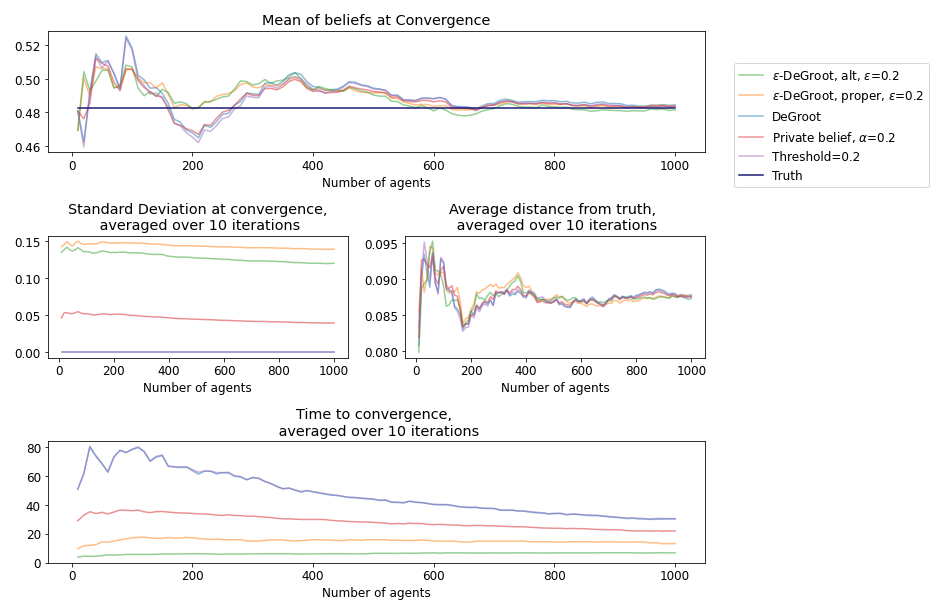

In [37]:
Image(filename=IMAGE_PATH+'WisdomCompare0.png') 

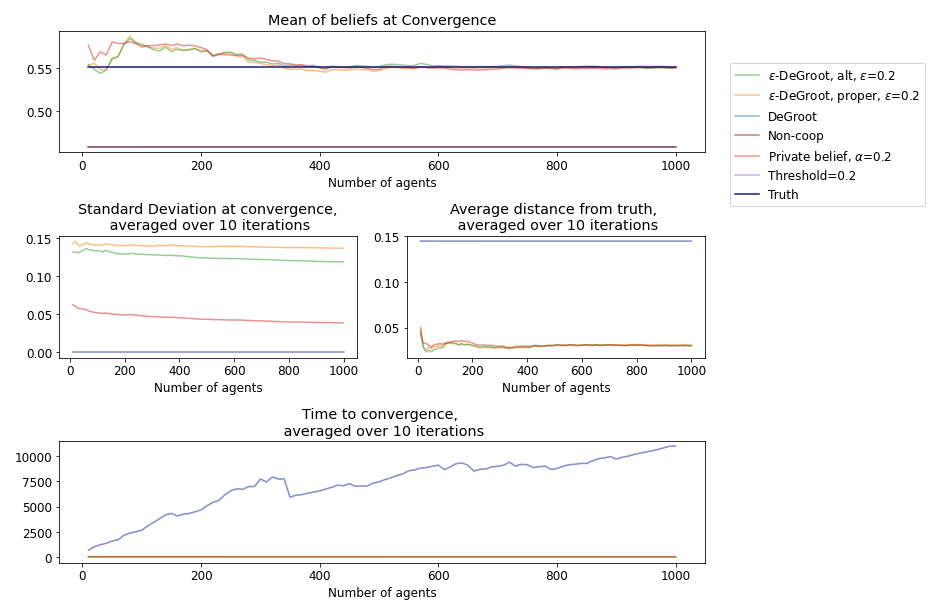

In [38]:
Image(filename=IMAGE_PATH+'WisdomCompare1.png') 

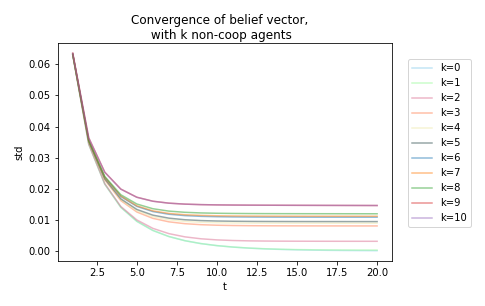

In [39]:
Image(filename=IMAGE_PATH+'CoopNonCoopConvergence10.png')

In [ ]:
def test_prob_functions(iterations=1000, *args):
    funcs = args[0]
    params = args[1]
    
    p_func_outcomes = []
    for p_func, param in zip(funcs, params):
        for i in range(iterations):
            outcome = p_func(*param)
            if type(outcome) != float:
                outcome = outcome[0]
            if i ==3:
                outcome=3*outcome
            outcome = int(round(outcome))
            p_func_outcomes.append(outcome)
            
    plt.hist(p_func_outcomes[:iterations], bins=np.amax(p_func_outcomes[:iterations]), 
             color="skyblue", label="gamma", edgecolor="slategrey")
    plt.show()
    plt.hist(p_func_outcomes[iterations:2*iterations], bins=np.amax(p_func_outcomes[iterations:2*iterations]), 
             color="coral", label="normal", edgecolor="slategrey")
    plt.show()
    plt.hist(p_func_outcomes[2*iterations:3*iterations], bins=np.amax(p_func_outcomes[2*iterations:3*iterations]), 
             color="palegreen", label="exponential", edgecolor="slategrey")    
    plt.show()
    plt.hist(p_func_outcomes[3*iterations:4*iterations], bins=np.amax(p_func_outcomes[3*iterations:4*iterations]), 
             color="lightcyan", label="laplace", edgecolor="slategrey")    
    plt.show()
    plt.hist(p_func_outcomes[4*iterations:], bins=np.amax(p_func_outcomes[4*iterations:]), 
             color="palegoldenrod", label="poisson", edgecolor="slategrey")    
    plt.show()
    return
prob_funcs = [np.random.gamma, np.random.normal, np.random.exponential, 
              np.random.laplace, np.random.poisson]
prob_params = ((4, .8), (4, 1), (1.5,1), (2, 1), (2, 1))

test_prob_functions(1000, prob_funcs, prob_params)
sns.light_palette("seagreen", as_cmap=True)


test = np.array([[2, 2], [3, 4]])
x=2
y=x
y+=3
print(x)

In [ ]:
def compare_speeds(network_size, power):
    matrix = np.random.normal(size=(network_size, network_size))

    

    t_start = time.perf_counter()
    np.linalg.matrix_power(matrix, power)
    t_end = time.perf_counter()
    print(f"Matrix power function: {t_end-t_start}s")

    matrix0 = matrix
    t_start = time.perf_counter()
    for i in range(power):
        matrix = matrix @ matrix0
    t_end = time.perf_counter()
    print(f"Iteratively: {t_end-t_start}s")

cudaRuntimeGetVersion()

In [ ]:
start_time = time.perf_counter()
np_test = np.random.normal(0, 1, (10000, 10000))
end_time = time.perf_counter()
print(f"Array creation numpy: {(end_time-start_time)*1000}")


start_time = time.perf_counter()
cp_test = cp.random.normal(0, 1, (100, 100))
cp.cuda.Stream.null.synchronize()
end_time = time.perf_counter()
print(f"Array creation cupy: {(end_time-start_time)*1000}")

In [ ]:
test  =np.array([1, 2])
print(test.reshape((2,1)))

In [ ]:
P = np.array([.32, .84, .64, .27])

print("P - P transpose")
delta = np.abs(P - P.reshape(P.shape[0], 1))
print(delta)


P2 = np.array([.42, .73, .61, .35])


P2_stacked = np.vstack([P2 for i in range(P2.shape[0])])
print("P2 - P2 transpose")
delta2 = np.abs(P2 - P2.reshape(P2.shape[0], 1))
print(delta2)

print("(P - P transpose) - (P2 - P2 transpose)")
print(delta-delta2)

print(np.abs(P - P.reshape(P.shape[0], 1)) - np.abs(P2 - P2.reshape(P2.shape[0], 1)))

In [ ]:
import sys
print(sys.version)